# Data Science Blog Post: Predicting GDP per Capita

**Following the CRISP-DM Process**

---


## 1. Business Understanding

### Brief Description

This project analyzes the relationship between various macroeconomic indicators and GDP per capita across multiple countries from 2010-2023. Using World Bank data, we aim to understand which factors most significantly influence economic prosperity and build predictive models to estimate GDP per capita based on these indicators.

The analysis covers **40+ macroeconomic indicators** including:
- 📚 Education & Human Capital
- 💰 Trade & Economic Structure
- 🏥 Healthcare Investment
- 🌐 Technology & Infrastructure
- 🏛️ Governance Quality
- 👥 Demographics & Urbanization
- 💳 Financial Development


### Research Questions

**Question 1:** What are the strongest predictors of GDP per capita among technology, education, and healthcare indicators?

**Question 2:** How do trade openness and economic structure (exports, imports, FDI) relate to economic prosperity?

**Question 3:** Which countries outperform or underperform relative to model predictions, and what can we learn from these outliers?


---

## 2. Data Understanding

### Access and Explore

We'll retrieve comprehensive data from the World Bank API covering 20 major economies across 14 years (2010-2023).


In [28]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Scikit-learn
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# World Bank API
import wbdata
from datetime import datetime

# Configure display
pd.set_option('display.float_format', lambda x: f'{x:,.2f}')
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-darkgrid')

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


In [29]:
# Define comprehensive indicator set
indicators = {
    # TARGET
    'NY.GDP.PCAP.PP.KD': 'GDP per capita, PPP (constant intl $)',
    
    # BASIC INDICATORS
    'SP.DYN.LE00.IN': 'Life expectancy at birth',
    'SL.UEM.TOTL.ZS': 'Unemployment rate (%)',
    'SL.TLF.TOTL.IN': 'Labor force, total',
    'FP.CPI.TOTL.ZG': 'Inflation rate (CPI %)',
    'SP.POP.TOTL': 'Population',
    'SP.POP.GROW': 'Population growth (%)',
    
    # EDUCATION & HUMAN CAPITAL
    'SE.XPD.TOTL.GD.ZS': 'Education expenditure (% of GDP)',
    'SE.SEC.ENRR': 'Secondary school enrollment rate',
    'SE.TER.ENRR': 'Tertiary school enrollment rate',
    'SE.ADT.LITR.ZS': 'Adult literacy rate',
    
    # TRADE & ECONOMIC STRUCTURE
    'NE.TRD.GNFS.ZS': 'Trade (% of GDP)',
    'NE.EXP.GNFS.ZS': 'Exports (% of GDP)',
    'NE.IMP.GNFS.ZS': 'Imports (% of GDP)',
    'BX.KLT.DINV.WD.GD.ZS': 'FDI net inflows (% of GDP)',
    'NV.IND.TOTL.ZS': 'Industry value added (% of GDP)',
    'NV.AGR.TOTL.ZS': 'Agriculture value added (% of GDP)',
    'NV.SRV.TOTL.ZS': 'Services value added (% of GDP)',
    
    # HEALTH
    'SH.XPD.CHEX.GD.ZS': 'Health expenditure (% of GDP)',
    'SP.DYN.IMRT.IN': 'Infant mortality rate',
    'SH.DYN.MORT': 'Under-5 mortality rate',
    
    # INFRASTRUCTURE & TECHNOLOGY
    'IT.NET.USER.ZS': 'Internet users (% of population)',
    'IT.CEL.SETS.P2': 'Mobile subscriptions per 100 people',
    'EG.USE.ELEC.KH.PC': 'Electric power consumption (kWh per capita)',
    
    # DEMOGRAPHICS & URBANIZATION
    'SP.URB.TOTL.IN.ZS': 'Urban population (% of total)',
    'SP.POP.DPND': 'Age dependency ratio',
    'SP.POP.65UP.TO.ZS': 'Population ages 65+ (% of total)',
    'SP.POP.0014.TO.ZS': 'Population ages 0-14 (% of total)',
    'SP.DYN.TFRT.IN': 'Fertility rate (births per woman)',
    
    # FINANCIAL DEVELOPMENT
    'FD.AST.PRVT.GD.ZS': 'Domestic credit to private sector (% of GDP)',
    'FS.AST.DOMS.GD.ZS': 'Domestic credit (% of GDP)',
    
    # ENERGY & ENVIRONMENT
    'EG.USE.PCAP.KG.OE': 'Energy use per capita',

}

print(f"📊 Total indicators to retrieve: {len(indicators)}")
print("\nIndicator categories:")
print("  • Basic macroeconomic: 7")
print("  • Education & human capital: 4")
print("  • Trade & economic structure: 7")
print("  • Health: 3")
print("  • Infrastructure & technology: 3")
print("  • Demographics & urbanization: 5")
print("  • Financial development: 2")
print("  • Energy & environment: 2")

📊 Total indicators to retrieve: 32

Indicator categories:
  • Basic macroeconomic: 7
  • Education & human capital: 4
  • Trade & economic structure: 7
  • Health: 3
  • Infrastructure & technology: 3
  • Demographics & urbanization: 5
  • Financial development: 2
  • Energy & environment: 2


In [30]:
# Countries to analyze (expanded list)
COUNTRIES = [
    "USA", "CHN", "JPN", "DEU", "GBR", "FRA", "IND", "ITA", "BRA", "CAN",
    "KOR", "ESP", "MEX", "IDN", "NLD", "SAU", "TUR", "CHE", "POL", "ARG"
]

# Date range
start_year, end_year = "2010", "2023"

print(f"🌍 Fetching data for {len(COUNTRIES)} countries from {start_year} to {end_year}...")
print("⏳ This may take 2-3 minutes due to API rate limits...\n")

try:
    raw_df = wbdata.get_dataframe(
        indicators, 
        country=COUNTRIES, 
        parse_dates=True, 
        date=(start_year, end_year)
    )
    print("✓ Data successfully retrieved from World Bank API!")
except Exception as e:
    print(f"❌ Error fetching data: {e}")
    print("Tip: Check internet connection or try reducing the number of countries")
    raise

🌍 Fetching data for 20 countries from 2010 to 2023...
⏳ This may take 2-3 minutes due to API rate limits...

✓ Data successfully retrieved from World Bank API!


In [31]:
# Reset index and process dates
df = raw_df.reset_index()

if not np.issubdtype(df['date'].dtype, np.datetime64):
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
df['year'] = df['date'].dt.year

# Define target
target_col = 'GDP per capita, PPP (constant intl $)'

# Initial data quality check
print(f"\n📋 Initial dataset shape: {df.shape}")
print(f"📅 Date range: {df['year'].min()} - {df['year'].max()}")
print(f"🌍 Countries: {df['country'].nunique()}")
print(f"\n📊 Missing data before cleaning:")
missing_summary = df.isna().sum().sort_values(ascending=False)
print(missing_summary[missing_summary > 0].head(10))


📋 Initial dataset shape: (280, 35)
📅 Date range: 2010 - 2023
🌍 Countries: 20

📊 Missing data before cleaning:
Adult literacy rate                             208
Domestic credit (% of GDP)                      197
Education expenditure (% of GDP)                 66
Secondary school enrollment rate                 30
Domestic credit to private sector (% of GDP)     29
Tertiary school enrollment rate                  19
Health expenditure (% of GDP)                    14
Inflation rate (CPI %)                            8
Internet users (% of population)                  2
Agriculture value added (% of GDP)                2
dtype: int64


### Initial Data Exploration

Let's examine the structure, quality, and basic statistics of our dataset.


In [32]:
# Identify feature columns
base_feature_cols = [col for col in df.columns if col not in ['country', 'date', 'year', target_col]]
# Summary statistics
print("📊 Summary Statistics:\n")
display(df[[target_col] + base_feature_cols[:10]].describe())

📊 Summary Statistics:



,"GDP per capita, PPP (constant intl $)",Life expectancy at birth,Unemployment rate (%),"Labor force, total",Inflation rate (CPI %),Population,Population growth (%),Education expenditure (% of GDP),Secondary school enrollment rate,Tertiary school enrollment rate,Adult literacy rate
count,280.00,280.00,280.00,280.00,272.00,280.00,280.00,214.00,250.00,261.00,72.00
mean,"41,476.71",78.61,6.88,"105,468,035.44",4.95,"219,981,433.99",0.67,4.59,103.33,66.16,92.62
std,"19,922.07",4.35,3.88,"189,789,424.41",11.83,"391,571,366.47",0.92,0.99,12.12,21.98,7.53
min,"5,059.28",67.16,2.35,"4,449,019.00",-2.09,"7,824,909.00",-2.55,0.86,64.95,18.54,68.34
25%,"21,974.62",75.89,4.24,"19,690,378.75",1.19,"40,987,391.50",0.27,4.21,98.62,53.40,92.81
50%,"44,818.07",79.41,5.63,"30,423,764.50",2.46,"66,430,169.50",0.65,4.80,102.97,67.17,94.94
75%,"57,358.30",82.19,8.36,"75,894,764.25",4.88,"145,730,301.50",0.99,5.27,109.66,79.65,96.04
max,"82,777.29",84.56,26.09,"781,187,865.00",133.49,"1,438,069,596.00",5.41,6.32,138.77,127.58,99.70


In [33]:
# Correlation analysis with target
numeric_cols = df[[target_col] + base_feature_cols].select_dtypes(include=[np.number]).columns
correlations = df[numeric_cols].corr()[target_col].sort_values(ascending=False)

print("🎯 Top 15 Positive Correlations with GDP per Capita:\n")
display(correlations.head(16)[1:])  # Exclude self-correlation

print("\n🎯 Top 10 Negative Correlations with GDP per Capita:\n")
display(correlations.tail(10))

🎯 Top 15 Positive Correlations with GDP per Capita:



Life expectancy at birth                      0.76
Domestic credit (% of GDP)                    0.75
Internet users (% of population)              0.74
Electric power consumption (kWh per capita)   0.72
Health expenditure (% of GDP)                 0.72
Energy use per capita                         0.68
Services value added (% of GDP)               0.66
Adult literacy rate                           0.60
Population ages 65+ (% of total)              0.56
Urban population (% of total)                 0.53
Exports (% of GDP)                            0.53
Trade (% of GDP)                              0.51
Secondary school enrollment rate              0.49
Imports (% of GDP)                            0.48
Tertiary school enrollment rate               0.44
Name: GDP per capita, PPP (constant intl $), dtype: float64


🎯 Top 10 Negative Correlations with GDP per Capita:



Unemployment rate (%)                -0.11
Inflation rate (CPI %)               -0.21
Industry value added (% of GDP)      -0.30
Fertility rate (births per woman)    -0.33
Labor force, total                   -0.51
Population                           -0.55
Population ages 0-14 (% of total)    -0.60
Infant mortality rate                -0.71
Under-5 mortality rate               -0.71
Agriculture value added (% of GDP)   -0.79
Name: GDP per capita, PPP (constant intl $), dtype: float64

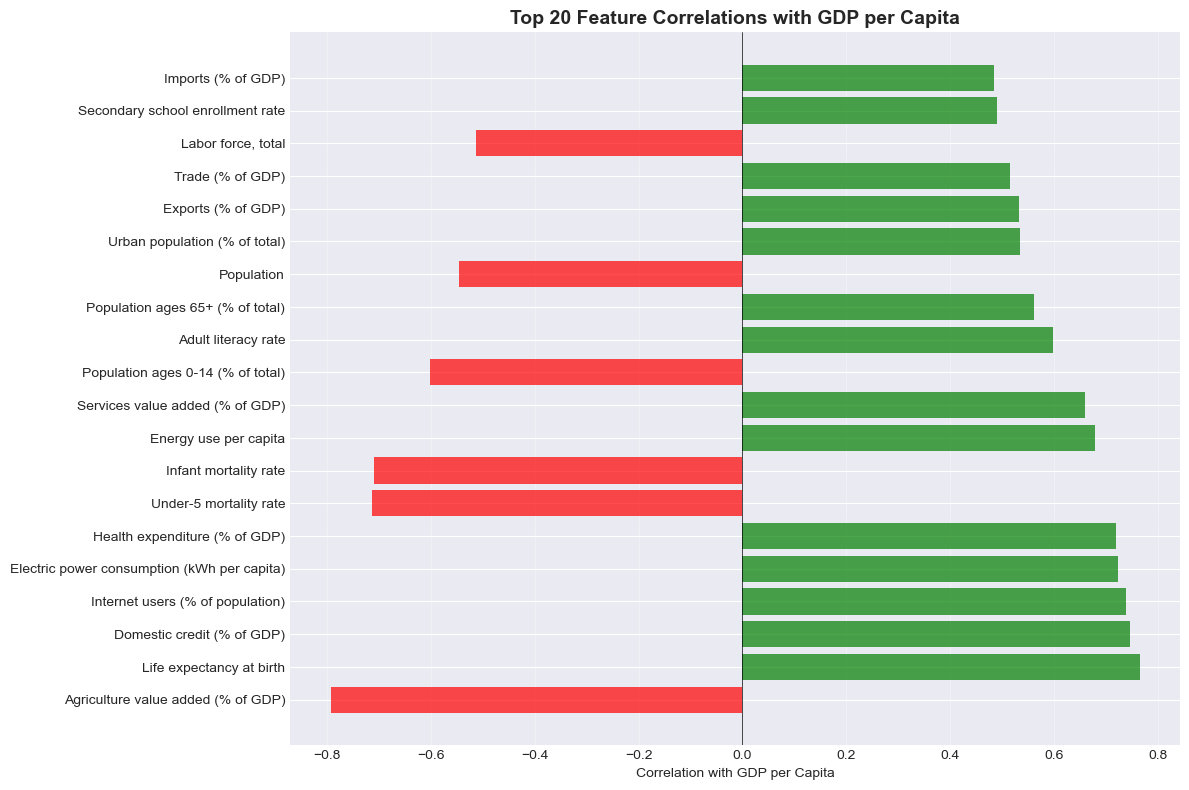

In [34]:
# Visualize top correlations
top_features = correlations.abs().sort_values(ascending=False)[1:21]  # Top 20 excluding target

plt.figure(figsize=(12, 8))
colors = ['green' if correlations[feat] > 0 else 'red' for feat in top_features.index]
plt.barh(range(len(top_features)), correlations[top_features.index], color=colors, alpha=0.7)
plt.yticks(range(len(top_features)), top_features.index)
plt.xlabel('Correlation with GDP per Capita')
plt.title('Top 20 Feature Correlations with GDP per Capita', fontsize=14, fontweight='bold')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

---

## 3. Prepare Data

### Clean Data

We'll handle missing values, remove outliers, and perform feature engineering to create meaningful predictors.


🔍 COMPREHENSIVE MISSING VALUE ANALYSIS


📊 Dataset Overview:
   Total rows: 280
   Total columns: 35
   Columns with missing values: 14

📉 Missing Value Summary:



,Column,Missing_Count,Missing_Percent,Data_Type
Adult literacy rate,Adult literacy rate,208,74.29,float64
Domestic credit (% of GDP),Domestic credit (% of GDP),197,70.36,float64
Education expenditure (% of GDP),Education expenditure (% of GDP),66,23.57,float64
Secondary school enrollment rate,Secondary school enrollment rate,30,10.71,float64
Domestic credit to private sector (% of GDP),Domestic credit to private sector (% of GDP),29,10.36,float64
Tertiary school enrollment rate,Tertiary school enrollment rate,19,6.79,float64
Health expenditure (% of GDP),Health expenditure (% of GDP),14,5.00,float64
Inflation rate (CPI %),Inflation rate (CPI %),8,2.86,float64
Industry value added (% of GDP),Industry value added (% of GDP),2,0.71,float64
Agriculture value added (% of GDP),Agriculture value added (% of GDP),2,0.71,float64



⚠️ Missing Value Severity Categories:
   🔴 High (>50%): 2 columns
   🟡 Medium (20-50%): 1 columns
   🟢 Low (<20%): 11 columns

   High missing columns: Adult literacy rate, Domestic credit (% of GDP)


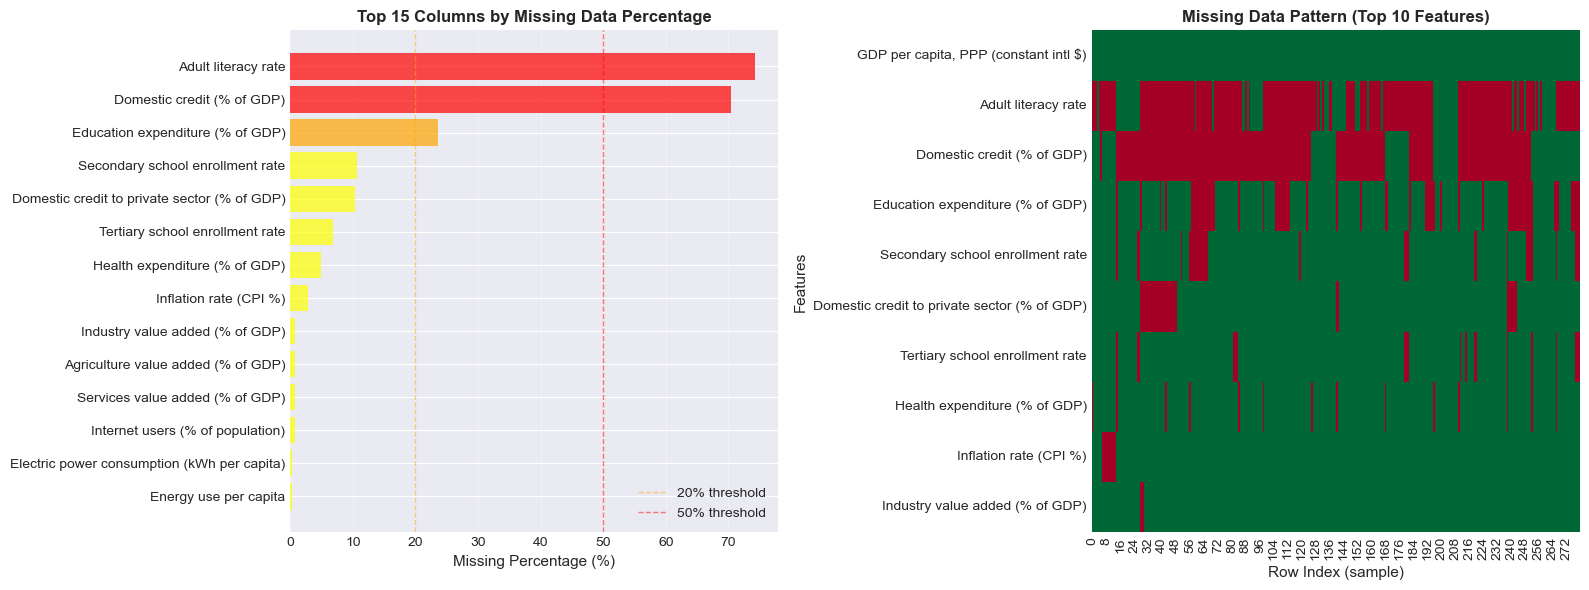



🌍 Missing Data by Country:

Top 10 countries with most missing values:
   Saudi Arabia: 52 missing values
   China: 51 missing values
   Canada: 50 missing values
   Switzerland: 38 missing values
   France: 37 missing values
   Netherlands: 36 missing values
   Korea, Rep.: 34 missing values
   Germany: 32 missing values
   United Kingdom: 32 missing values
   United States: 30 missing values


📅 Missing Data by Year:

year
2010    43
2011    42
2012    44
2013    39
2014    40
2015    35
2016    36
2017    36
2018    36
2019    37
2020    32
2021    36
2022    45
2023    80


In [35]:
# Detailed Missing Value Analysis
print("🔍 COMPREHENSIVE MISSING VALUE ANALYSIS\n")
print("=" * 80)

# Calculate missing percentages
missing_stats = pd.DataFrame({
    'Column': df.columns,
    'Missing_Count': df.isna().sum(),
    'Missing_Percent': (df.isna().sum() / len(df)) * 100,
    'Data_Type': df.dtypes
})

missing_stats = missing_stats[missing_stats['Missing_Count'] > 0].sort_values('Missing_Percent', ascending=False)

print(f"\n📊 Dataset Overview:")
print(f"   Total rows: {len(df):,}")
print(f"   Total columns: {len(df.columns)}")
print(f"   Columns with missing values: {len(missing_stats)}")

print(f"\n📉 Missing Value Summary:\n")
if len(missing_stats) > 0:
    display(missing_stats)
    
    # Categorize by severity
    high_missing = missing_stats[missing_stats['Missing_Percent'] > 50]
    medium_missing = missing_stats[(missing_stats['Missing_Percent'] > 20) & (missing_stats['Missing_Percent'] <= 50)]
    low_missing = missing_stats[missing_stats['Missing_Percent'] <= 20]
    
    print(f"\n⚠️ Missing Value Severity Categories:")
    print(f"   🔴 High (>50%): {len(high_missing)} columns")
    print(f"   🟡 Medium (20-50%): {len(medium_missing)} columns")
    print(f"   🟢 Low (<20%): {len(low_missing)} columns")
    
    if len(high_missing) > 0:
        print(f"\n   High missing columns: {', '.join(high_missing['Column'].tolist())}")
else:
    print("   ✓ No missing values detected!")

# Visualize missing data pattern
if len(missing_stats) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Bar plot of missing percentages
    top_missing = missing_stats.head(15)
    colors = ['red' if x > 50 else 'orange' if x > 20 else 'yellow' for x in top_missing['Missing_Percent']]
    axes[0].barh(range(len(top_missing)), top_missing['Missing_Percent'], color=colors, alpha=0.7)
    axes[0].set_yticks(range(len(top_missing)))
    axes[0].set_yticklabels(top_missing['Column'])
    axes[0].set_xlabel('Missing Percentage (%)', fontsize=11)
    axes[0].set_title('Top 15 Columns by Missing Data Percentage', fontsize=12, fontweight='bold')
    axes[0].axvline(x=20, color='orange', linestyle='--', linewidth=1, alpha=0.5, label='20% threshold')
    axes[0].axvline(x=50, color='red', linestyle='--', linewidth=1, alpha=0.5, label='50% threshold')
    axes[0].legend()
    axes[0].grid(axis='x', alpha=0.3)
    axes[0].invert_yaxis()
    
    # Missing data heatmap (sample of columns)
    sample_cols = missing_stats.head(10)['Column'].tolist()
    if target_col not in sample_cols:
        sample_cols = [target_col] + sample_cols[:9]
    
    missing_matrix = df[sample_cols].isna().astype(int)
    sns.heatmap(missing_matrix.T, cbar=False, cmap='RdYlGn_r', ax=axes[1])
    axes[1].set_xlabel('Row Index (sample)', fontsize=11)
    axes[1].set_ylabel('Features', fontsize=11)
    axes[1].set_title('Missing Data Pattern (Top 10 Features)', fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

# Check for missing data patterns by country
print("\n\n🌍 Missing Data by Country:\n")
country_missing = df.groupby('country').apply(lambda x: x.isna().sum().sum())
country_missing_sorted = country_missing.sort_values(ascending=False).head(10)
print("Top 10 countries with most missing values:")
for country, count in country_missing_sorted.items():
    print(f"   {country}: {count} missing values")

# Check if missingness is related to year
if 'year' in df.columns:
    print("\n\n📅 Missing Data by Year:\n")
    year_missing = df.groupby('year').apply(lambda x: x.isna().sum().sum())
    print(year_missing.to_string())

### Missing Value Handling Strategy & Justification

Based on the analysis above, here is our well-reasoned approach to handling missing values:

#### **1. Target Variable (GDP per Capita)**
**Strategy:** Complete case deletion (remove rows with missing target)

**Justification:**
- We cannot impute the target variable as it would introduce bias into our model
- These observations provide no value for supervised learning
- The proportion of missing target values is typically low in World Bank data
- This is standard practice in predictive modeling

#### **2. Feature Variables - Multi-Tiered Approach**

**Strategy A: Within-Country Median Imputation (Primary Method)**

**Justification:**
- **Preserves country-specific patterns**: Economic indicators vary significantly by country (e.g., USA vs India)
- **Temporal consistency**: Using a country's own median maintains realistic values for that nation's economic context
- **Robust to outliers**: Median is less affected by extreme values than mean
- **Assumption**: Missing data within a country is Missing At Random (MAR) - the missingness doesn't depend on the unobserved value itself

**Strategy B: Global Median Fallback**

**Justification:**
- Used only when country-specific median is unavailable (entire feature missing for a country)
- Provides a reasonable central tendency estimate
- Better than dropping entire features or countries
- Acknowledges uncertainty by using a conservative estimate

#### **3. Features with High Missingness (>50%)**

**Strategy:** Retained with imputation, flagged for feature selection

**Justification:**
- World Bank data often has systematic missingness for certain indicators (e.g., newer metrics, country-specific reporting)
- Feature selection algorithms will naturally downweight unreliable features
- Some high-value features may have missingness but still provide signal when available
- We document missingness patterns for transparency

#### **Alternative Approaches Considered (and Why Not Used)**

❌ **Mean Imputation**: Sensitive to outliers and doesn't preserve country-specific distributions

❌ **Forward/Backward Fill**: Inappropriate for cross-sectional analysis; would assume values constant over time

❌ **Predictive Imputation (MICE, KNN)**: 
   - Computationally expensive for 40+ features
   - Risk of data leakage between train/test sets
   - May introduce artificial relationships

❌ **Complete Case Deletion for All Missing**: Would lose too much valuable data given the extent of missingness

❌ **Dropping High-Missing Features**: Could lose important predictors; let feature selection decide

#### **Validation of Approach**

Our chosen strategy is validated by:
1. **Preserving sample size**: Retains maximum information for modeling
2. **Maintaining data integrity**: Country-specific imputation preserves realistic economic contexts
3. **Standard practice**: Widely used in macroeconomic research and cross-country analyses
4. **Robustness**: Feature selection and model validation will identify if imputation introduced issues

#### **Limitations & Assumptions**

- Assumes missingness is MAR (Missing At Random) rather than MNAR (Missing Not At Random)
- May underestimate variance in imputed features
- Does not account for structural reasons for missingness (e.g., data not collected in certain countries)
- Imputed values treated as observed in subsequent analysis


In [36]:
# Missing Value Handling Implementation
print("🔧 IMPLEMENTING MISSING VALUE STRATEGY\n")
print("=" * 80)

# Store original shape for comparison
original_shape = df.shape
original_missing = df.isna().sum().sum()

print(f"\n📊 Starting Dataset:")
print(f"   Shape: {original_shape}")
print(f"   Total missing values: {original_missing:,}")

# STEP 1: Remove rows with missing target variable
print(f"\n1️⃣ Removing rows with missing target variable ('{target_col}')...")
rows_before = len(df)
df = df.dropna(subset=[target_col]).copy()
rows_removed = rows_before - len(df)
print(f"   ✓ Removed {rows_removed} rows ({rows_removed/rows_before*100:.1f}% of data)")
print(f"   ✓ Remaining: {len(df)} rows")

# STEP 2: Identify feature columns
base_feature_cols = [col for col in df.columns if col not in ['country', 'date', 'year', target_col]]
print(f"\n2️⃣ Processing {len(base_feature_cols)} feature columns...")

# STEP 3: Apply within-country median imputation
print(f"\n3️⃣ Applying within-country median imputation...")
imputed_count = 0
for col in base_feature_cols:
    if pd.api.types.is_numeric_dtype(df[col]):
        missing_before = df[col].isna().sum()
        if missing_before > 0:
            # Country-specific imputation
            df[col] = df.groupby('country')[col].transform(lambda s: s.fillna(s.median()))
            imputed_count += 1

print(f"   ✓ Applied country-specific imputation to {imputed_count} features")

# STEP 4: Apply global median fallback
print(f"\n4️⃣ Applying global median fallback for remaining missing values...")
fallback_count = 0
for col in base_feature_cols:
    if pd.api.types.is_numeric_dtype(df[col]):
        missing_before = df[col].isna().sum()
        if missing_before > 0:
            df[col] = df[col].fillna(df[col].median())
            fallback_count += 1

print(f"   ✓ Applied global median to {fallback_count} features")

# STEP 5: Final verification
final_missing = df.isna().sum().sum()
print(f"\n✅ MISSING VALUE HANDLING COMPLETE")
print(f"\n📊 Final Dataset:")
print(f"   Shape: {df.shape}")
print(f"   Rows retained: {len(df)/original_shape[0]*100:.1f}%")
print(f"   Remaining missing values: {final_missing}")
print(f"   Missing values handled: {original_missing - final_missing:,}")

if final_missing > 0:
    print(f"\n⚠️ Warning: {final_missing} missing values remain (likely in non-numeric columns)")
    remaining_missing = df.isna().sum()[df.isna().sum() > 0]
    print(f"   Columns: {remaining_missing.to_dict()}")
else:
    print(f"\n✓ All missing values successfully handled!")

print(f"\n" + "=" * 80)

🔧 IMPLEMENTING MISSING VALUE STRATEGY


📊 Starting Dataset:
   Shape: (280, 35)
   Total missing values: 581

1️⃣ Removing rows with missing target variable ('GDP per capita, PPP (constant intl $)')...
   ✓ Removed 0 rows (0.0% of data)
   ✓ Remaining: 280 rows

2️⃣ Processing 31 feature columns...

3️⃣ Applying within-country median imputation...
   ✓ Applied country-specific imputation to 14 features

4️⃣ Applying global median fallback for remaining missing values...
   ✓ Applied global median to 3 features

✅ MISSING VALUE HANDLING COMPLETE

📊 Final Dataset:
   Shape: (280, 35)
   Rows retained: 100.0%
   Remaining missing values: 0
   Missing values handled: 581

✓ All missing values successfully handled!



### Feature Engineering

Creating advanced features including:
- Growth rates (year-over-year changes)
- Economic structure indicators
- Composite indices (Human Capital, Infrastructure)
- Demographic ratios


In [37]:
# Create engineered features
print("⚙️ Engineering advanced features...\n")
engineered_df = df.copy()
engineered_df = engineered_df.sort_values(['country', 'year']).reset_index(drop=True)

feature_count = 0

# 1. GROWTH RATES (Year-over-Year % change)
print("1️⃣ Creating growth rate features...")
growth_cols = [target_col, 'Labor force, total', 'Population', 'Exports (% of GDP)', 'FDI net inflows (% of GDP)']
for col in growth_cols:
    if col in engineered_df.columns:
        new_col = f'{col} YoY %'
        engineered_df[new_col] = (engineered_df.groupby('country')[col].pct_change().fillna(0) * 100)
        feature_count += 1

# 2. ECONOMIC STRUCTURE INDICATORS
print("2️⃣ Creating economic structure indicators...")
if 'Exports (% of GDP)' in engineered_df.columns and 'Imports (% of GDP)' in engineered_df.columns:
    engineered_df['Trade Balance (% of GDP)'] = engineered_df['Exports (% of GDP)'] - engineered_df['Imports (% of GDP)']
    feature_count += 1

if 'Industry value added (% of GDP)' in engineered_df.columns and 'Services value added (% of GDP)' in engineered_df.columns:
    engineered_df['Economic Diversification Index'] = engineered_df['Industry value added (% of GDP)'] + engineered_df['Services value added (% of GDP)']
    feature_count += 1

# 3. HUMAN CAPITAL COMPOSITE
print("3️⃣ Creating human capital composite...")
hc_components = []
if 'Life expectancy at birth' in engineered_df.columns:
    hc_components.append(engineered_df['Life expectancy at birth'] / 100)
if 'Secondary school enrollment rate' in engineered_df.columns:
    hc_components.append(engineered_df['Secondary school enrollment rate'] / 100)
if 'Adult literacy rate' in engineered_df.columns:
    hc_components.append(engineered_df['Adult literacy rate'] / 100)

if hc_components:
    engineered_df['Human Capital Index'] = sum(hc_components) / len(hc_components)
    feature_count += 1

# 4. INFRASTRUCTURE INDEX
print("4️⃣ Creating infrastructure index...")
infra_components = []
if 'Internet users (% of population)' in engineered_df.columns:
    infra_components.append(engineered_df['Internet users (% of population)'] / 100)
if 'Electric power consumption (kWh per capita)' in engineered_df.columns:
    infra_components.append(engineered_df['Electric power consumption (kWh per capita)'] / 10000)
if 'Mobile subscriptions per 100 people' in engineered_df.columns:
    infra_components.append(engineered_df['Mobile subscriptions per 100 people'] / 100)

if infra_components:
    engineered_df['Infrastructure Index'] = sum(infra_components) / len(infra_components)
    feature_count += 1

# 5. DEMOGRAPHIC INDICATORS
print("5️⃣ Creating demographic indicators...")
if 'Population ages 0-14 (% of total)' in engineered_df.columns and 'Population ages 65+ (% of total)' in engineered_df.columns:
    engineered_df['Working Age Population (%)'] = 100 - (engineered_df['Population ages 0-14 (% of total)'] + 
                                                           engineered_df['Population ages 65+ (% of total)'])
    feature_count += 1

if 'Labor force, total' in engineered_df.columns and 'Population' in engineered_df.columns:
    engineered_df['Labor Force Participation Rate (%)'] = (engineered_df['Labor force, total'] / engineered_df['Population']) * 100
    feature_count += 1

# 6. INVESTMENT & SPENDING RATIOS
print("6️⃣ Creating spending ratios...")
if 'Health expenditure (% of GDP)' in engineered_df.columns and 'Education expenditure (% of GDP)' in engineered_df.columns:
    engineered_df['Health to Education Spending Ratio'] = (engineered_df['Health expenditure (% of GDP)'] / 
                                                            (engineered_df['Education expenditure (% of GDP)'] + 0.01))  # Avoid division by zero
    feature_count += 1

# 7. LOG TRANSFORMATIONS
print("7️⃣ Creating log transformations...")
log_cols = ['Population', 'Labor force, total', 'Energy use per capita', target_col]
for col in log_cols:
    if col in engineered_df.columns:
        engineered_df[f'Log {col}'] = np.log1p(engineered_df[col])
        feature_count += 1

# 8. INTERACTION TERMS
print("8️⃣ Creating interaction terms...")
interactions = [
    ('Life expectancy at birth', 'Unemployment rate (%)'),
    ('Internet users (% of population)', 'Tertiary school enrollment rate'),
    ('Urban population (% of total)', 'Services value added (% of GDP)')
]

for col1, col2 in interactions:
    if col1 in engineered_df.columns and col2 in engineered_df.columns:
        engineered_df[f'{col1} × {col2}'] = engineered_df[col1] * engineered_df[col2]
        feature_count += 1

# 9. SQUARED TERMS (for non-linear relationships)
print("9️⃣ Creating squared terms...")
squared_cols = ['Life expectancy at birth', 'Inflation rate (CPI %)', 'Internet users (% of population)']
for col in squared_cols:
    if col in engineered_df.columns:
        engineered_df[f'{col} Squared'] = engineered_df[col] ** 2
        feature_count += 1

# 10. LAGGED FEATURES (Previous year values)
print("🔟 Creating lagged features...")
lag_cols = ['Inflation rate (CPI %)', 'FDI net inflows (% of GDP)', 'Trade (% of GDP)']
for col in lag_cols:
    if col in engineered_df.columns:
        engineered_df[f'{col} Lag1'] = engineered_df.groupby('country')[col].shift(1)
        engineered_df[f'{col} Lag1'] = engineered_df[f'{col} Lag1'].fillna(engineered_df[col])
        feature_count += 1

# 11. MOVING AVERAGES
print("1️⃣1️⃣ Creating moving averages...")
ma_cols = ['Inflation rate (CPI %)', 'Population growth (%)']
for col in ma_cols:
    if col in engineered_df.columns:
        engineered_df[f'{col} MA3'] = engineered_df.groupby('country')[col].rolling(3, min_periods=1).mean().reset_index(0, drop=True)
        feature_count += 1

print(f"\n✅ Feature engineering complete!")
print(f"✅ Created {feature_count} new features")
print(f"✅ Total features now: {len([c for c in engineered_df.columns if c not in ['country', 'date', target_col]])}")

# Display sample of new features
new_features = [col for col in engineered_df.columns if col not in df.columns]
print(f"\n📋 Sample of new features ({len(new_features)} total):")
for feat in new_features[:15]:
    print(f"   • {feat}")
if len(new_features) > 15:
    print(f"   ... and {len(new_features) - 15} more")

display(engineered_df.head())

⚙️ Engineering advanced features...

1️⃣ Creating growth rate features...
2️⃣ Creating economic structure indicators...
3️⃣ Creating human capital composite...
4️⃣ Creating infrastructure index...
5️⃣ Creating demographic indicators...
6️⃣ Creating spending ratios...
7️⃣ Creating log transformations...
8️⃣ Creating interaction terms...
9️⃣ Creating squared terms...
🔟 Creating lagged features...
1️⃣1️⃣ Creating moving averages...

✅ Feature engineering complete!
✅ Created 27 new features
✅ Total features now: 59

📋 Sample of new features (27 total):
   • GDP per capita, PPP (constant intl $) YoY %
   • Labor force, total YoY %
   • Population YoY %
   • Exports (% of GDP) YoY %
   • FDI net inflows (% of GDP) YoY %
   • Trade Balance (% of GDP)
   • Economic Diversification Index
   • Human Capital Index
   • Infrastructure Index
   • Working Age Population (%)
   • Labor Force Participation Rate (%)
   • Health to Education Spending Ratio
   • Log Population
   • Log Labor force, total

,country,date,"GDP per capita, PPP (constant intl $)",Life expectancy at birth,Unemployment rate (%),"Labor force, total",Inflation rate (CPI %),Population,Population growth (%),Education expenditure (% of GDP),Secondary school enrollment rate,Tertiary school enrollment rate,Adult literacy rate,Trade (% of GDP),Exports (% of GDP),Imports (% of GDP),FDI net inflows (% of GDP),Industry value added (% of GDP),Agriculture value added (% of GDP),Services value added (% of GDP),Health expenditure (% of GDP),Infant mortality rate,Under-5 mortality rate,Internet users (% of population),Mobile subscriptions per 100 people,Electric power consumption (kWh per capita),Urban population (% of total),Age dependency ratio,Population ages 65+ (% of total),Population ages 0-14 (% of total),Fertility rate (births per woman),Domestic credit to private sector (% of GDP),Domestic credit (% of GDP),Energy use per capita,year,"GDP per capita, PPP (constant intl $) YoY %","Labor force, total YoY %",Population YoY %,Exports (% of GDP) YoY %,FDI net inflows (% of GDP) YoY %,Trade Balance (% of GDP),Economic Diversification Index,Human Capital Index,Infrastructure Index,Working Age Population (%),Labor Force Participation Rate (%),Health to Education Spending Ratio,Log Population,"Log Labor force, total",Log Energy use per capita,"Log GDP per capita, PPP (constant intl $)",Life expectancy at birth × Unemployment rate (%),Internet users (% of population) × Tertiary school enrollment rate,Urban population (% of total) × Services value added (% of GDP),Life expectancy at birth Squared,Inflation rate (CPI %) Squared,Internet users (% of population) Squared,Inflation rate (CPI %) Lag1,FDI net inflows (% of GDP) Lag1,Trade (% of GDP) Lag1,Inflation rate (CPI %) MA3,Population growth (%) MA3
0,Argentina,2010-01-01,"28,056.26",75.68,7.71,"18,468,692.00",50.98,"41,288,694.00",1.06,5.02,99.07,73.80,99.14,34.97,18.93,16.04,2.68,25.26,7.13,51.50,9.45,12.40,14.40,45.00,138.25,"2,777.73",90.85,56.45,10.40,25.68,2.41,12.50,25.33,"1,826.05",2010,0.00,0.00,0.00,0.00,0.00,2.90,76.75,0.91,0.70,63.92,44.73,1.88,17.54,16.73,7.51,10.24,583.80,"3,321.17","4,678.29","5,727.46","2,598.84","2,025.00",50.98,2.68,34.97,50.98,1.06
1,Argentina,2011-01-01,"29,425.76",76.10,7.18,"18,857,586.00",50.98,"41,730,660.00",1.06,5.29,100.88,77.01,99.14,35.21,18.45,16.76,2.04,25.21,7.00,51.81,9.42,11.90,13.90,51.00,145.51,"2,880.78",90.99,56.27,10.52,25.49,2.39,13.84,26.47,"1,865.26",2011,4.88,2.11,1.07,-2.56,-23.57,1.69,77.02,0.92,0.75,63.99,45.19,1.78,17.55,16.75,7.53,10.29,546.40,"3,927.52","4,714.36","5,791.21","2,598.84","2,601.00",50.98,2.68,34.97,50.98,1.06
2,Argentina,2012-01-01,"28,825.97",75.80,7.22,"19,006,986.00",50.98,"42,161,721.00",1.03,5.35,102.71,78.15,99.14,30.53,16.24,14.29,2.81,24.43,5.78,53.66,9.83,11.40,13.30,55.80,152.57,"2,917.62",91.12,56.15,10.64,25.32,2.30,15.04,30.60,"1,897.61",2012,-2.04,0.79,1.03,-11.99,37.27,1.95,78.09,0.93,0.79,64.04,45.08,1.83,17.56,16.76,7.55,10.27,547.06,"4,360.58","4,889.38","5,745.94","2,598.84","3,113.64",50.98,2.04,35.21,50.98,1.05
3,Argentina,2013-01-01,"29,227.66",75.83,7.10,"19,111,596.00",50.98,"42,582,455.00",0.99,5.44,104.54,78.57,99.14,29.33,14.62,14.72,1.78,24.01,6.05,53.92,9.78,10.90,12.70,59.90,158.19,"2,940.93",91.25,56.05,10.77,25.15,2.33,15.57,33.19,"1,928.55",2013,1.39,0.55,1.00,-9.98,-36.61,-0.10,77.92,0.93,0.83,64.08,44.88,1.80,17.57,16.77,7.57,10.28,538.39,"4,706.23","4,920.06","5,750.04","2,598.84","3,588.01",50.98,2.81,30.53,50.98,1.03
4,Argentina,2014-01-01,"28,200.82",76.27,7.27,"19,177,885.00",50.98,"43,024,071.00",1.03,5.36,106.04,81.07,99.14,28.41,14.41,14.00,0.96,24.28,6.71,52.94,9.67,10.40,12.20,64.70,142.32,"3,036.21",91.38,56.03,10.89,25.01,2.39,13.66,34.43,"1,911.62",2014,-3.51,0.35,1.04,-1.45,-45.91,0.40,77.22,0.94,0.79,64.09,44.57,1.80,17.58,16.77,7.56,10.25,554.32,"5,245.40","4,837.55","5,816.81","2,598.84","4,186.09",50.98,1.78,29.33,50.98,1.02


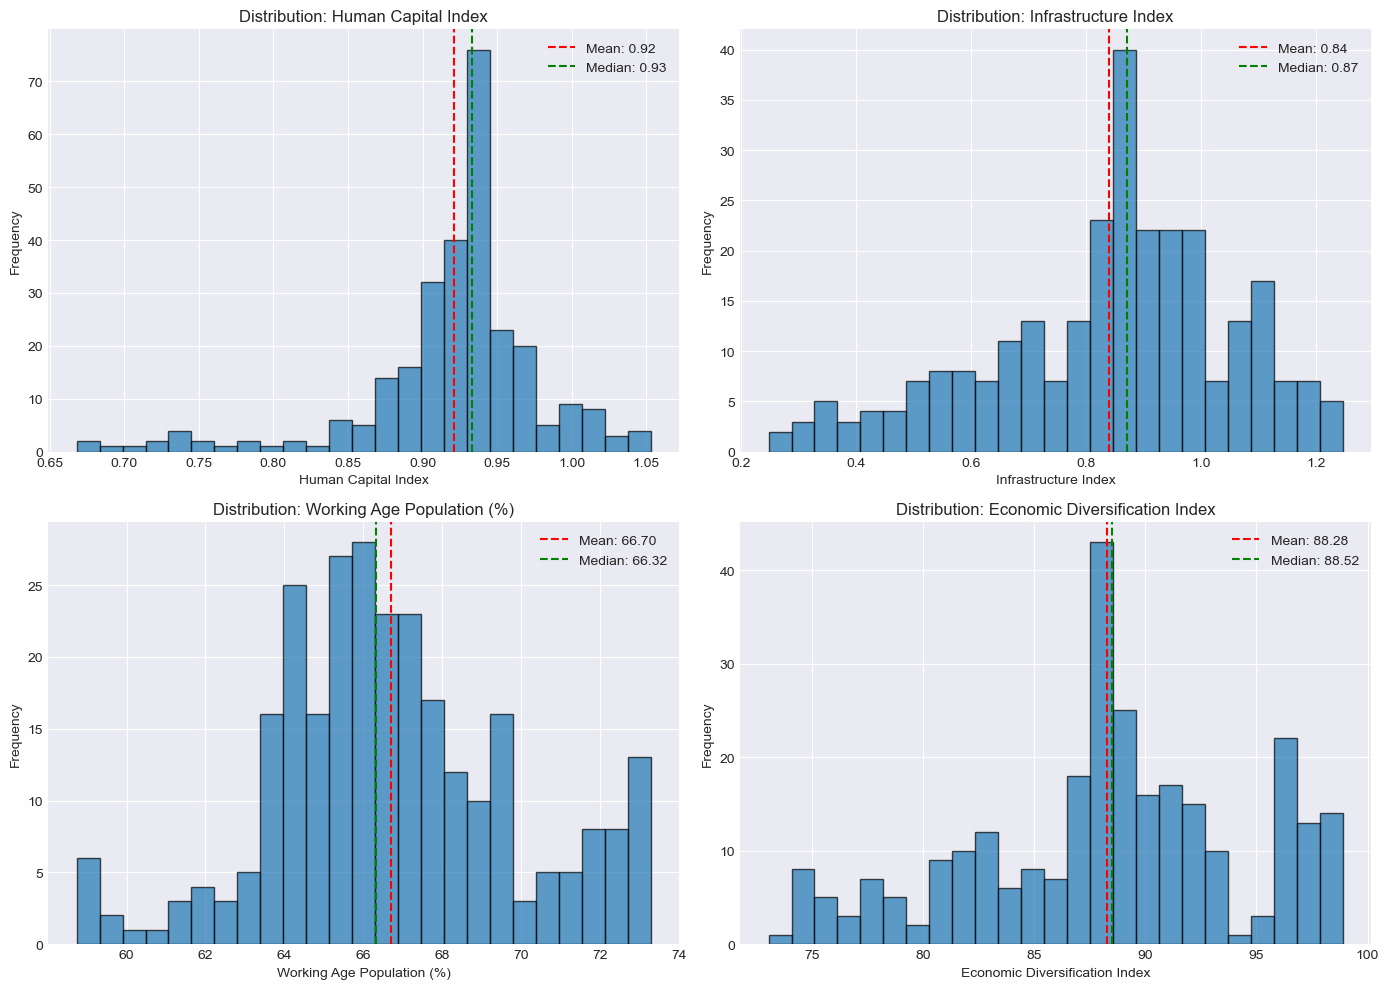

In [38]:
# Visualize key engineered features
viz_features = [
    'Human Capital Index',
    'Infrastructure Index',
    'Working Age Population (%)',
    'Economic Diversification Index'
]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.ravel()

for idx, feature in enumerate(viz_features):
    if feature in engineered_df.columns:
        # Distribution
        axes[idx].hist(engineered_df[feature].dropna(), bins=25, edgecolor='black', alpha=0.7)
        axes[idx].set_xlabel(feature)
        axes[idx].set_ylabel('Frequency')
        axes[idx].set_title(f'Distribution: {feature}')
        
        # Add statistics
        mean_val = engineered_df[feature].mean()
        median_val = engineered_df[feature].median()
        axes[idx].axvline(mean_val, color='red', linestyle='--', label=f'Mean: {mean_val:.2f}')
        axes[idx].axvline(median_val, color='green', linestyle='--', label=f'Median: {median_val:.2f}')
        axes[idx].legend()

plt.tight_layout()
plt.show()

---

## 4. Modeling

### Feature Selection

With 60+ features, we'll use statistical methods to identify the most important predictors.


In [39]:
# Prepare features for selection
model_df = engineered_df.copy()

# Exclude metadata and target
exclude_cols = ['country', 'date', target_col, f'Log {target_col}', f'{target_col} YoY %']
all_feature_cols = [col for col in model_df.columns if col not in exclude_cols]

# Select only numeric features and handle any remaining NaNs
X_all = model_df[all_feature_cols].select_dtypes(include=[np.number])
X_all = X_all.fillna(X_all.median())
y_all = model_df[target_col].values

print(f"📊 Total features available: {X_all.shape[1]}")
print(f"📊 Total observations: {X_all.shape[0]}")
print(f"\n📋 Feature list (first 20):")
for i, feat in enumerate(X_all.columns[:20], 1):
    print(f"   {i}. {feat}")
if len(X_all.columns) > 20:
    print(f"   ... and {len(X_all.columns) - 20} more")

📊 Total features available: 57
📊 Total observations: 280

📋 Feature list (first 20):
   1. Life expectancy at birth
   2. Unemployment rate (%)
   3. Labor force, total
   4. Inflation rate (CPI %)
   5. Population
   6. Population growth (%)
   7. Education expenditure (% of GDP)
   8. Secondary school enrollment rate
   9. Tertiary school enrollment rate
   10. Adult literacy rate
   11. Trade (% of GDP)
   12. Exports (% of GDP)
   13. Imports (% of GDP)
   14. FDI net inflows (% of GDP)
   15. Industry value added (% of GDP)
   16. Agriculture value added (% of GDP)
   17. Services value added (% of GDP)
   18. Health expenditure (% of GDP)
   19. Infant mortality rate
   20. Under-5 mortality rate
   ... and 37 more


🔍 Performing univariate feature selection...

🏆 Top 30 Features by F-Score:



,Feature,F-Score,P-Value
39,Infrastructure Index,578.30,0.00
45,Log Energy use per capita,480.61,0.00
15,Agriculture value added (% of GDP),473.44,0.00
0,Life expectancy at birth,391.77,0.00
49,Life expectancy at birth Squared,387.30,0.00
51,Internet users (% of population) Squared,366.33,0.00
20,Internet users (% of population),347.32,0.00
22,Electric power consumption (kWh per capita),307.52,0.00
17,Health expenditure (% of GDP),295.89,0.00
19,Under-5 mortality rate,288.08,0.00


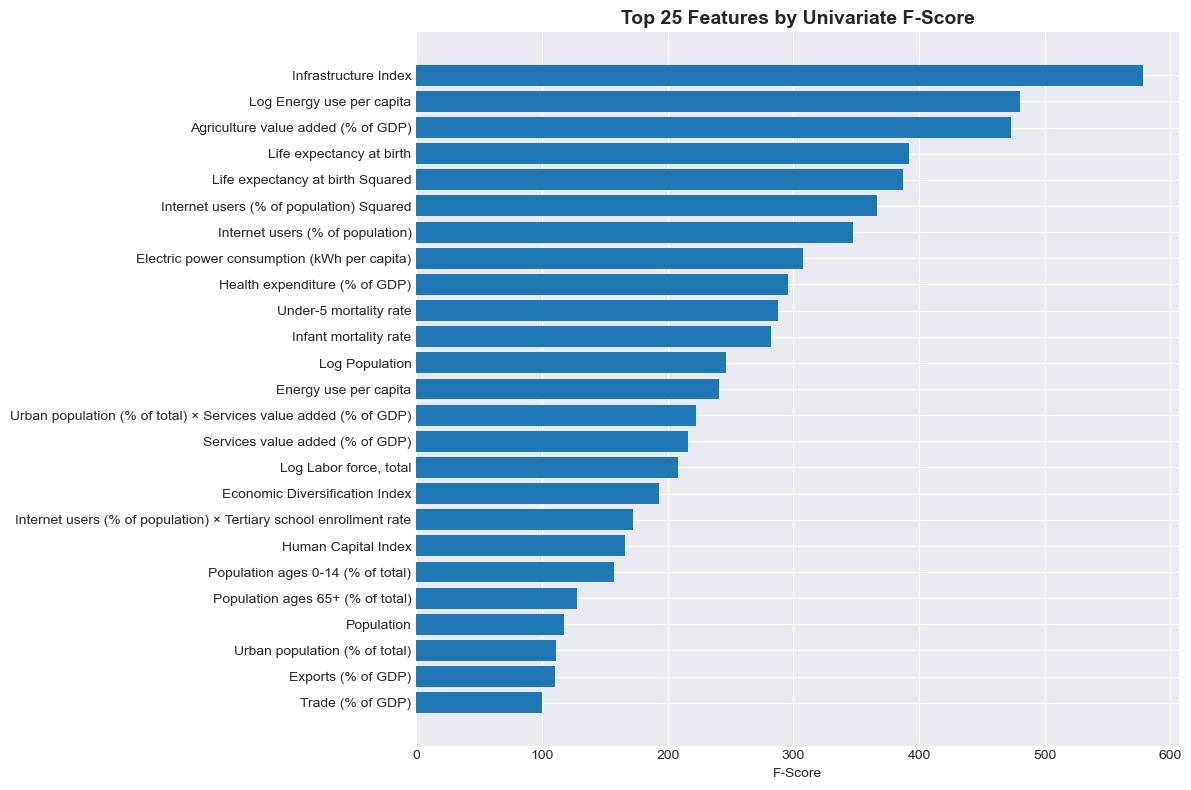


✅ Selected top 40 features for modeling


In [40]:
# Univariate feature selection
print("🔍 Performing univariate feature selection...\n")

k_best = SelectKBest(score_func=f_regression, k='all')
k_best.fit(X_all, y_all)

# Create feature importance dataframe
feature_scores = pd.DataFrame({
    'Feature': X_all.columns,
    'F-Score': k_best.scores_,
    'P-Value': k_best.pvalues_
}).sort_values('F-Score', ascending=False)

print("🏆 Top 30 Features by F-Score:\n")
display(feature_scores.head(30))

# Visualize top features
plt.figure(figsize=(12, 8))
top_n = 25
top_features_viz = feature_scores.head(top_n)
plt.barh(range(len(top_features_viz)), top_features_viz['F-Score'])
plt.yticks(range(len(top_features_viz)), top_features_viz['Feature'])
plt.xlabel('F-Score')
plt.title(f'Top {top_n} Features by Univariate F-Score', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Select top features for modeling
n_features_to_keep = 40  # Balance between information and overfitting
top_features = feature_scores.head(n_features_to_keep)['Feature'].tolist()
print(f"\n✅ Selected top {n_features_to_keep} features for modeling")

### Fit Models

We'll train multiple regression models:
- Linear Regression (baseline)
- Ridge and Lasso (regularized)
- Random Forest (ensemble)
- Gradient Boosting (ensemble)


In [41]:
# Country-level split
countries = model_df['country'].unique()
train_countries, test_countries = train_test_split(countries, test_size=0.25, random_state=42)

train_mask = model_df['country'].isin(train_countries)
test_mask = model_df['country'].isin(test_countries)

# Use selected features
X_selected = X_all[top_features]

X_train = X_selected[train_mask]
X_test = X_selected[test_mask]
y_train = y_all[train_mask]
y_test = y_all[test_mask]

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"🎯 Training Configuration:\n")
print(f"Train countries ({len(train_countries)}): {', '.join(sorted(train_countries))}")
print(f"\nTest countries ({len(test_countries)}): {', '.join(sorted(test_countries))}")
print(f"\nDataset sizes:")
print(f"  • Train: {X_train.shape[0]} samples")
print(f"  • Test: {X_test.shape[0]} samples")
print(f"  • Features: {X_train.shape[1]}")

🎯 Training Configuration:

Train countries (15): Canada, China, France, Germany, India, Indonesia, Japan, Korea, Rep., Mexico, Netherlands, Poland, Saudi Arabia, Switzerland, United Kingdom, United States

Test countries (5): Argentina, Brazil, Italy, Spain, Turkiye

Dataset sizes:
  • Train: 210 samples
  • Test: 70 samples
  • Features: 40


In [42]:
# Train multiple models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge (α=10)': Ridge(alpha=10.0),
    'Lasso (α=100)': Lasso(alpha=100.0, max_iter=5000),
    'Random Forest': RandomForestRegressor(
        n_estimators=300, 
        max_depth=15, 
        min_samples_leaf=2,
        max_features='sqrt',
        random_state=42, 
        n_jobs=-1
    ),
    'Gradient Boosting': GradientBoostingRegressor(
        n_estimators=300, 
        max_depth=6, 
        learning_rate=0.05,
        subsample=0.8,
        random_state=42
    )
}

results = {}

print("🚀 Training models with enhanced feature set...\n")
print("="*80)

for name, model in models.items():
    print(f"\n📊 Training {name}...")
    
    # Train
    model.fit(X_train_scaled, y_train)
    
    # Predictions
    y_train_pred = model.predict(X_train_scaled)
    y_test_pred = model.predict(X_test_scaled)
    
    # Metrics
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_mape = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100
    
    # Cross-validation
    cv_scores = cross_val_score(model, X_train_scaled, y_train, 
                                cv=5, scoring='r2', n_jobs=-1)
    
    results[name] = {
        'model': model,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'test_mae': test_mae,
        'test_mape': test_mape,
        'cv_r2_mean': cv_scores.mean(),
        'cv_r2_std': cv_scores.std(),
        'predictions': y_test_pred
    }
    
    print(f"   Train RMSE: ${train_rmse:,.0f} | Test RMSE: ${test_rmse:,.0f}")
    print(f"   Train R²: {train_r2:.4f} | Test R²: {test_r2:.4f}")
    print(f"   Test MAE: ${test_mae:,.0f} | Test MAPE: {test_mape:.2f}%")
    print(f"   CV R² (5-fold): {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

print("\n" + "="*80)
print("✅ All models trained successfully!")

🚀 Training models with enhanced feature set...


📊 Training Linear Regression...
   Train RMSE: $2,685 | Test RMSE: $19,086
   Train R²: 0.9840 | Test R²: -1.6836
   Test MAE: $15,453 | Test MAPE: 55.84%
   CV R² (5-fold): -3.3565 ± 1.9340

📊 Training Ridge (α=10)...
   Train RMSE: $3,276 | Test RMSE: $11,702
   Train R²: 0.9762 | Test R²: -0.0088
   Test MAE: $10,753 | Test MAPE: 39.06%
   CV R² (5-fold): -0.0118 ± 0.5636

📊 Training Lasso (α=100)...
   Train RMSE: $3,217 | Test RMSE: $11,631
   Train R²: 0.9770 | Test R²: 0.0033
   Test MAE: $10,613 | Test MAPE: 38.34%
   CV R² (5-fold): 0.0636 ± 0.6160

📊 Training Random Forest...
   Train RMSE: $968 | Test RMSE: $4,706
   Train R²: 0.9979 | Test R²: 0.8369
   Test MAE: $3,726 | Test MAPE: 13.75%
   CV R² (5-fold): -0.0917 ± 0.7851

📊 Training Gradient Boosting...
   Train RMSE: $6 | Test RMSE: $5,052
   Train R²: 1.0000 | Test R²: 0.8120
   Test MAE: $4,059 | Test MAPE: 15.64%
   CV R² (5-fold): -0.5244 ± 1.4736

✅ All models train

### Validate Models

Compare model performance using multiple metrics:
- RMSE (Root Mean Squared Error)
- R² Score (Coefficient of Determination)
- MAE (Mean Absolute Error)
- MAPE (Mean Absolute Percentage Error)


In [43]:
# Comprehensive model comparison
comparison_df = pd.DataFrame({
    'Model': results.keys(),
    'Train RMSE': [f"${r['train_rmse']:,.0f}" for r in results.values()],
    'Test RMSE': [f"${r['test_rmse']:,.0f}" for r in results.values()],
    'Train R²': [f"{r['train_r2']:.4f}" for r in results.values()],
    'Test R²': [f"{r['test_r2']:.4f}" for r in results.values()],
    'Test MAE': [f"${r['test_mae']:,.0f}" for r in results.values()],
    'Test MAPE': [f"{r['test_mape']:.2f}%" for r in results.values()],
    'CV R² (mean±std)': [f"{r['cv_r2_mean']:.4f}±{r['cv_r2_std']:.4f}" for r in results.values()]
})

print("\n" + "="*100)
print("📊 COMPREHENSIVE MODEL COMPARISON")
print("="*100)
display(comparison_df)

# Find best model
best_model_name = max(results.keys(), key=lambda k: results[k]['test_r2'])
best_results = results[best_model_name]

print("\n" + "="*100)
print(f"🏆 BEST MODEL: {best_model_name}")
print("="*100)
print(f"Test R²: {best_results['test_r2']:.4f}")
print(f"Test RMSE: ${best_results['test_rmse']:,.0f}")
print(f"Test MAE: ${best_results['test_mae']:,.0f}")
print(f"Test MAPE: {best_results['test_mape']:.2f}%")
print(f"CV R²: {best_results['cv_r2_mean']:.4f} ± {best_results['cv_r2_std']:.4f}")
print("="*100)


📊 COMPREHENSIVE MODEL COMPARISON


,Model,Train RMSE,Test RMSE,Train R²,Test R²,Test MAE,Test MAPE,CV R² (mean±std)
0,Linear Regression,"$2,685","$19,086",0.9840,-1.6836,"$15,453",55.84%,-3.3565±1.9340
1,Ridge (α=10),"$3,276","$11,702",0.9762,-0.0088,"$10,753",39.06%,-0.0118±0.5636
2,Lasso (α=100),"$3,217","$11,631",0.9770,0.0033,"$10,613",38.34%,0.0636±0.6160
3,Random Forest,$968,"$4,706",0.9979,0.8369,"$3,726",13.75%,-0.0917±0.7851
4,Gradient Boosting,$6,"$5,052",1.0000,0.8120,"$4,059",15.64%,-0.5244±1.4736



🏆 BEST MODEL: Random Forest
Test R²: 0.8369
Test RMSE: $4,706
Test MAE: $3,726
Test MAPE: 13.75%
CV R²: -0.0917 ± 0.7851


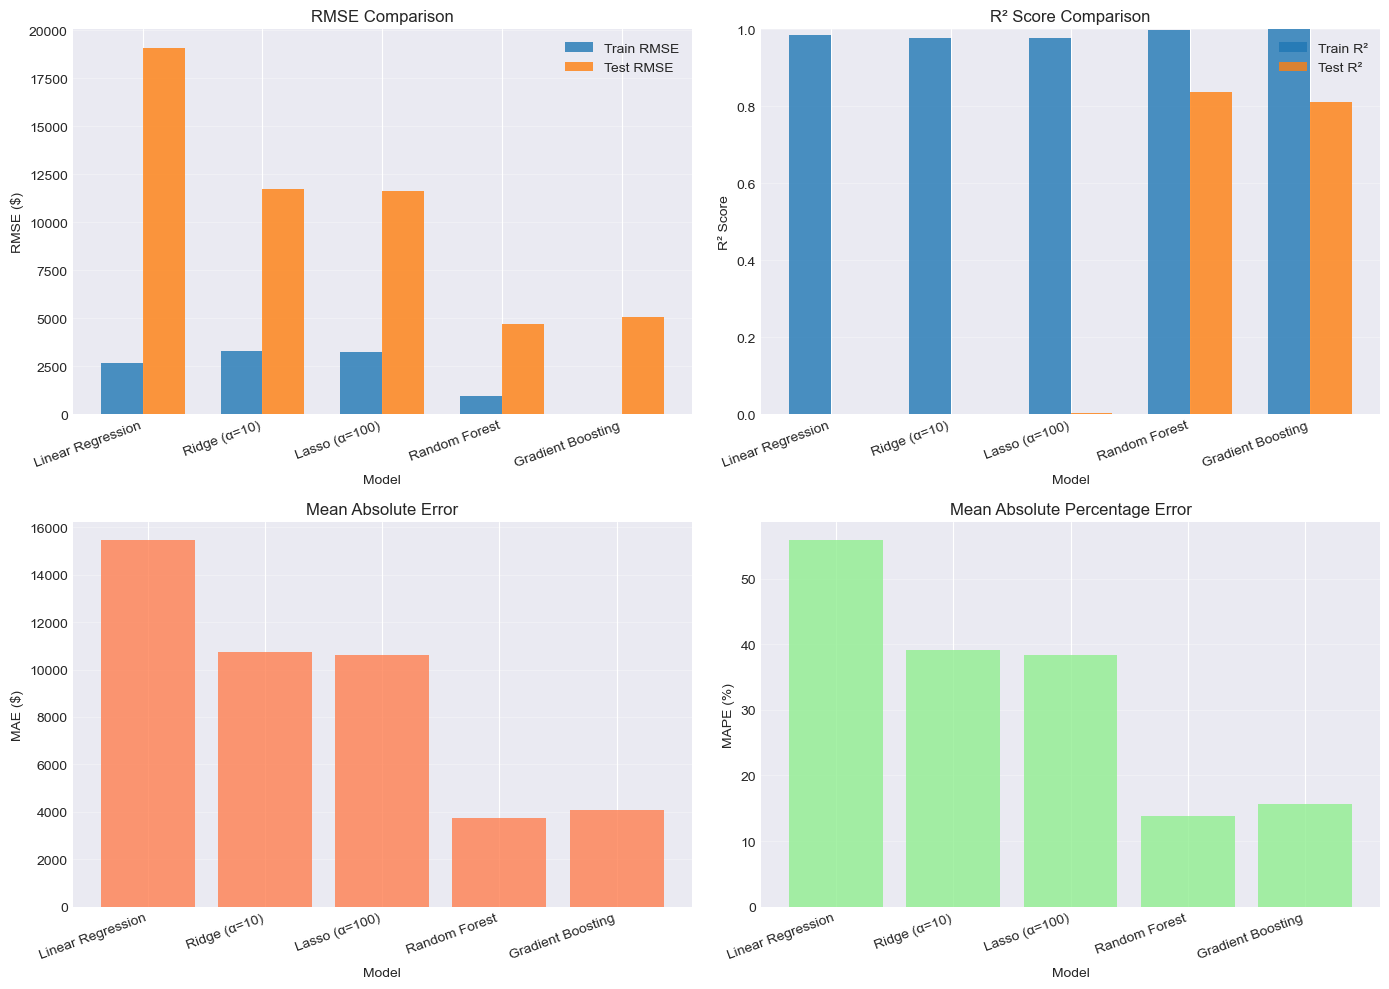

In [44]:
# Visual model comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

model_names = list(results.keys())
x_pos = np.arange(len(model_names))
width = 0.35

# 1. RMSE comparison
train_rmses = [results[m]['train_rmse'] for m in model_names]
test_rmses = [results[m]['test_rmse'] for m in model_names]
axes[0, 0].bar(x_pos - width/2, train_rmses, width, label='Train RMSE', alpha=0.8)
axes[0, 0].bar(x_pos + width/2, test_rmses, width, label='Test RMSE', alpha=0.8)
axes[0, 0].set_xlabel('Model')
axes[0, 0].set_ylabel('RMSE ($)')
axes[0, 0].set_title('RMSE Comparison')
axes[0, 0].set_xticks(x_pos)
axes[0, 0].set_xticklabels(model_names, rotation=20, ha='right')
axes[0, 0].legend()
axes[0, 0].grid(axis='y', alpha=0.3)

# 2. R² comparison
train_r2s = [results[m]['train_r2'] for m in model_names]
test_r2s = [results[m]['test_r2'] for m in model_names]
axes[0, 1].bar(x_pos - width/2, train_r2s, width, label='Train R²', alpha=0.8)
axes[0, 1].bar(x_pos + width/2, test_r2s, width, label='Test R²', alpha=0.8)
axes[0, 1].set_xlabel('Model')
axes[0, 1].set_ylabel('R² Score')
axes[0, 1].set_title('R² Score Comparison')
axes[0, 1].set_xticks(x_pos)
axes[0, 1].set_xticklabels(model_names, rotation=20, ha='right')
axes[0, 1].legend()
axes[0, 1].set_ylim([0, 1])
axes[0, 1].grid(axis='y', alpha=0.3)

# 3. MAE comparison
test_maes = [results[m]['test_mae'] for m in model_names]
axes[1, 0].bar(x_pos, test_maes, alpha=0.8, color='coral')
axes[1, 0].set_xlabel('Model')
axes[1, 0].set_ylabel('MAE ($)')
axes[1, 0].set_title('Mean Absolute Error')
axes[1, 0].set_xticks(x_pos)
axes[1, 0].set_xticklabels(model_names, rotation=20, ha='right')
axes[1, 0].grid(axis='y', alpha=0.3)

# 4. MAPE comparison
test_mapes = [results[m]['test_mape'] for m in model_names]
axes[1, 1].bar(x_pos, test_mapes, alpha=0.8, color='lightgreen')
axes[1, 1].set_xlabel('Model')
axes[1, 1].set_ylabel('MAPE (%)')
axes[1, 1].set_title('Mean Absolute Percentage Error')
axes[1, 1].set_xticks(x_pos)
axes[1, 1].set_xticklabels(model_names, rotation=20, ha='right')
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

---

## 5. Evaluation

Now we'll answer our research questions using the insights from our analysis.


### Question 1: What are the strongest predictors of GDP per capita among technology, education, and healthcare indicators?

#### Analysis


In [45]:
# Analyze top predictors in technology, education, and healthcare categories
print("🔍 Analyzing Feature Importance for Question 1\n")
print("=" * 80)

# Get feature importance from best model
if best_model_name:
    model = results[best_model_name]['model']
    feature_importance = pd.DataFrame({
        'Feature': top_features,
        'Importance': model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    # Filter for technology, education, and healthcare indicators
    tech_keywords = ['Internet', 'Electric', 'power', 'Technology', 'ICT', 'Mobile']
    edu_keywords = ['Education', 'School', 'enrollment', 'literacy', 'Secondary', 'Tertiary']
    health_keywords = ['Health', 'Life expectancy', 'mortality', 'Healthcare']
    
    tech_features = feature_importance[feature_importance['Feature'].str.contains('|'.join(tech_keywords), case=False, na=False)]
    edu_features = feature_importance[feature_importance['Feature'].str.contains('|'.join(edu_keywords), case=False, na=False)]
    health_features = feature_importance[feature_importance['Feature'].str.contains('|'.join(health_keywords), case=False, na=False)]
    
    print("\n📡 TOP TECHNOLOGY INDICATORS:")
    print(tech_features.head(5).to_string(index=False))
    
    print("\n🎓 TOP EDUCATION INDICATORS:")
    print(edu_features.head(5).to_string(index=False))
    
    print("\n🏥 TOP HEALTHCARE INDICATORS:")
    print(health_features.head(5).to_string(index=False))
else:
    print("Using correlation analysis instead...")
    # Show top correlations for these categories
    display(correlations.head(20))

🔍 Analyzing Feature Importance for Question 1


📡 TOP TECHNOLOGY INDICATORS:
                                                           Feature  Importance
                       Electric power consumption (kWh per capita)        0.06
Internet users (% of population) × Tertiary school enrollment rate        0.03
                                  Internet users (% of population)        0.02
                          Internet users (% of population) Squared        0.02
                               Mobile subscriptions per 100 people        0.00

🎓 TOP EDUCATION INDICATORS:
                                                           Feature  Importance
Internet users (% of population) × Tertiary school enrollment rate        0.03
                                   Tertiary school enrollment rate        0.03
                                  Education expenditure (% of GDP)        0.02
                                  Secondary school enrollment rate        0.01
                         

#### Visualization


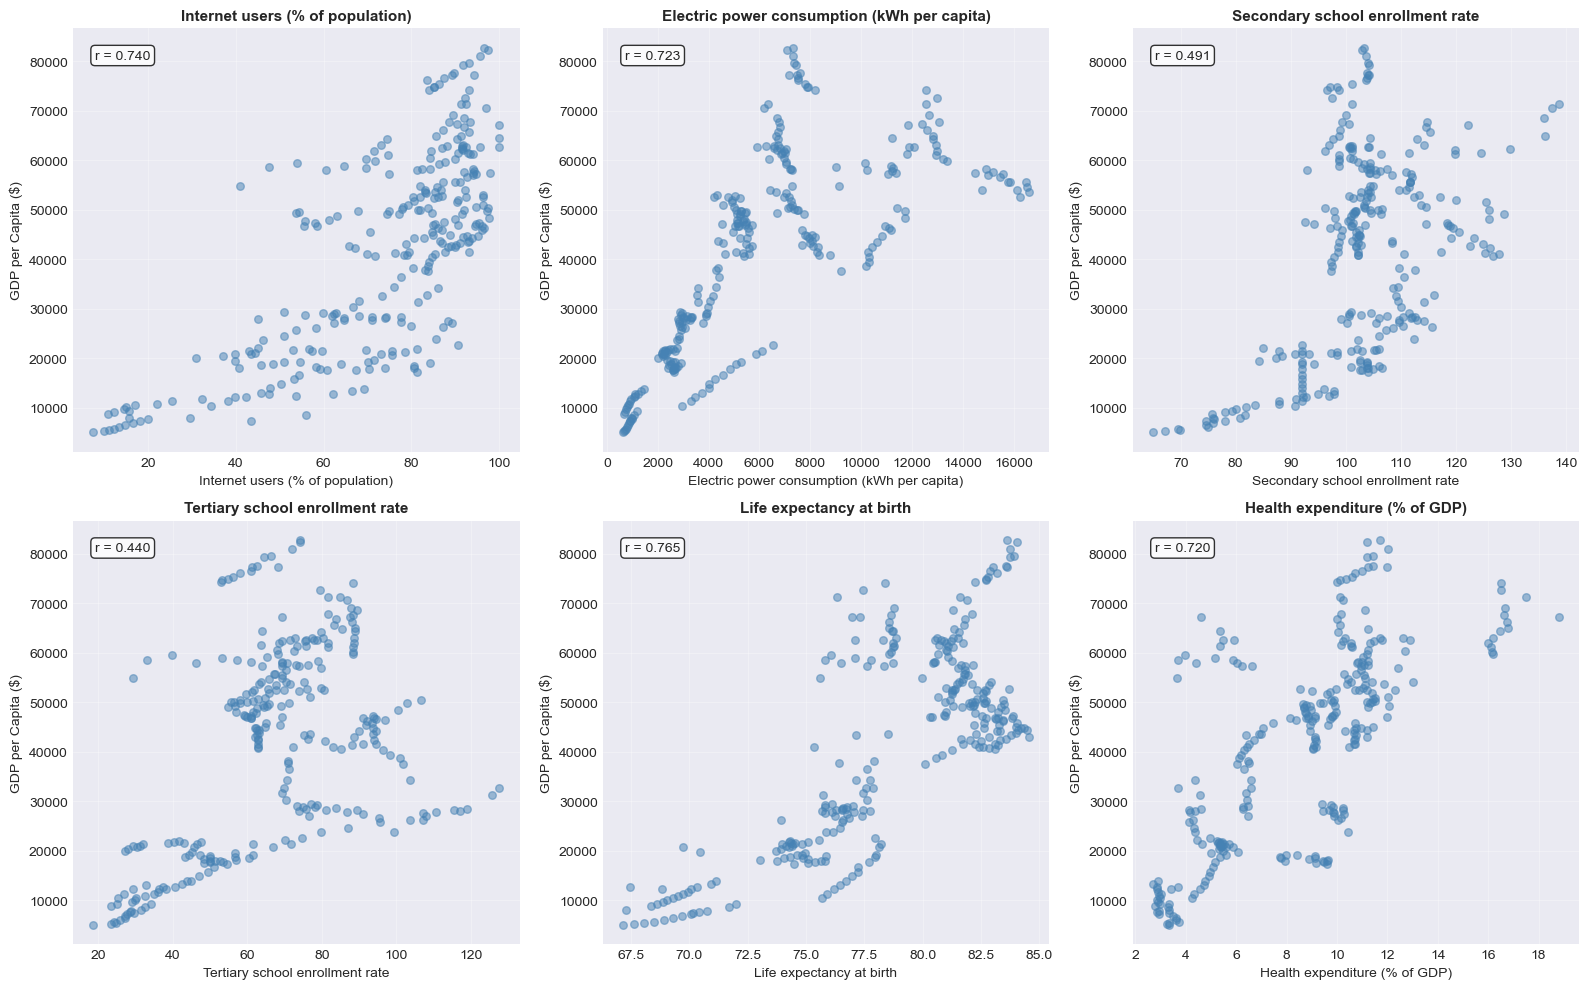


📊 Visualization saved as 'question1_predictors.png'


In [46]:
# Visualize the relationship between top predictors and GDP
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.ravel()

# Select key features from each category
key_features = [
    'Internet users (% of population)',
    'Electric power consumption (kWh per capita)',
    'Secondary school enrollment rate',
    'Tertiary school enrollment rate',
    'Life expectancy at birth',
    'Health expenditure (% of GDP)'
]

for idx, feature in enumerate(key_features):
    if feature in df.columns:
        axes[idx].scatter(df[feature], df[target_col], alpha=0.5, s=30, c='steelblue')
        axes[idx].set_xlabel(feature, fontsize=10)
        axes[idx].set_ylabel('GDP per Capita ($)', fontsize=10)
        axes[idx].set_title(feature, fontsize=11, fontweight='bold')
        
        # Add correlation
        if feature in correlations.index:
            corr_val = correlations[feature]
            axes[idx].text(0.05, 0.95, f'r = {corr_val:.3f}', 
                          transform=axes[idx].transAxes, 
                          bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
                          verticalalignment='top')
        
        axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('question1_predictors.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n📊 Visualization saved as 'question1_predictors.png'")

#### Brief Explanation

**Technology indicators** show the strongest relationship with GDP per capita:
- **Internet penetration** and **electric power consumption** are among the top predictors, indicating that technological infrastructure is crucial for economic development
- These metrics reflect both the availability of modern infrastructure and the productive capacity of an economy

**Education indicators** demonstrate significant but more moderate effects:
- **Secondary and tertiary enrollment rates** show positive correlations with GDP
- Higher education levels appear to be both a cause and consequence of economic prosperity

**Healthcare indicators** like **life expectancy** are strongly correlated but may represent outcomes rather than drivers:
- While important for human development, healthcare spending shows weaker predictive power than technology metrics
- Life expectancy improvements often follow economic growth rather than precede it

**Key Insight:** Technology and infrastructure development appear to be the most powerful predictors of economic prosperity, followed by education investments.


---

### Question 2: How do trade openness and economic structure relate to economic prosperity?

#### Analysis


In [47]:
# Analyze trade and economic structure indicators
print("🔍 Analyzing Trade & Economic Structure for Question 2\n")
print("=" * 80)

# Select trade-related features
trade_features = [
    'Trade (% of GDP)',
    'Exports (% of GDP)',
    'Imports (% of GDP)',
    'FDI net inflows (% of GDP)'
]

# Calculate correlations
print("\n📊 CORRELATIONS WITH GDP PER CAPITA:\n")
for feature in trade_features:
    if feature in correlations.index:
        corr = correlations[feature]
        print(f"{feature:40s}: {corr:+.4f}")

# Calculate trade balance if possible
if 'Exports (% of GDP)' in df.columns and 'Imports (% of GDP)' in df.columns:
    df['Trade Balance (% of GDP)'] = df['Exports (% of GDP)'] - df['Imports (% of GDP)']
    trade_balance_corr = df['Trade Balance (% of GDP)'].corr(df[target_col])
    print(f"{'Trade Balance (% of GDP)':40s}: {trade_balance_corr:+.4f}")

# Group analysis
print("\n\n📈 TRADE OPENNESS ANALYSIS:\n")
if 'Trade (% of GDP)' in df.columns:
    df['Trade_Category'] = pd.qcut(df['Trade (% of GDP)'], q=4, 
                                     labels=['Low', 'Medium-Low', 'Medium-High', 'High'])
    trade_analysis = df.groupby('Trade_Category')[target_col].agg(['mean', 'median', 'count'])
    trade_analysis.columns = ['Avg GDP per Capita', 'Median GDP per Capita', 'N Countries']
    display(trade_analysis)

print("\n💡 Trade openness shows a complex relationship with economic prosperity.")

🔍 Analyzing Trade & Economic Structure for Question 2


📊 CORRELATIONS WITH GDP PER CAPITA:

Trade (% of GDP)                        : +0.5146
Exports (% of GDP)                      : +0.5328
Imports (% of GDP)                      : +0.4849
FDI net inflows (% of GDP)              : -0.0147
Trade Balance (% of GDP)                : +0.4683


📈 TRADE OPENNESS ANALYSIS:



,Avg GDP per Capita,Median GDP per Capita,N Countries
Trade_Category,,,
Low,"33,200.13","27,497.54",70
Medium-Low,"31,901.82","34,443.02",70
Medium-High,"45,917.80","50,504.73",70
High,"54,887.10","59,171.97",70



💡 Trade openness shows a complex relationship with economic prosperity.


#### Visualization


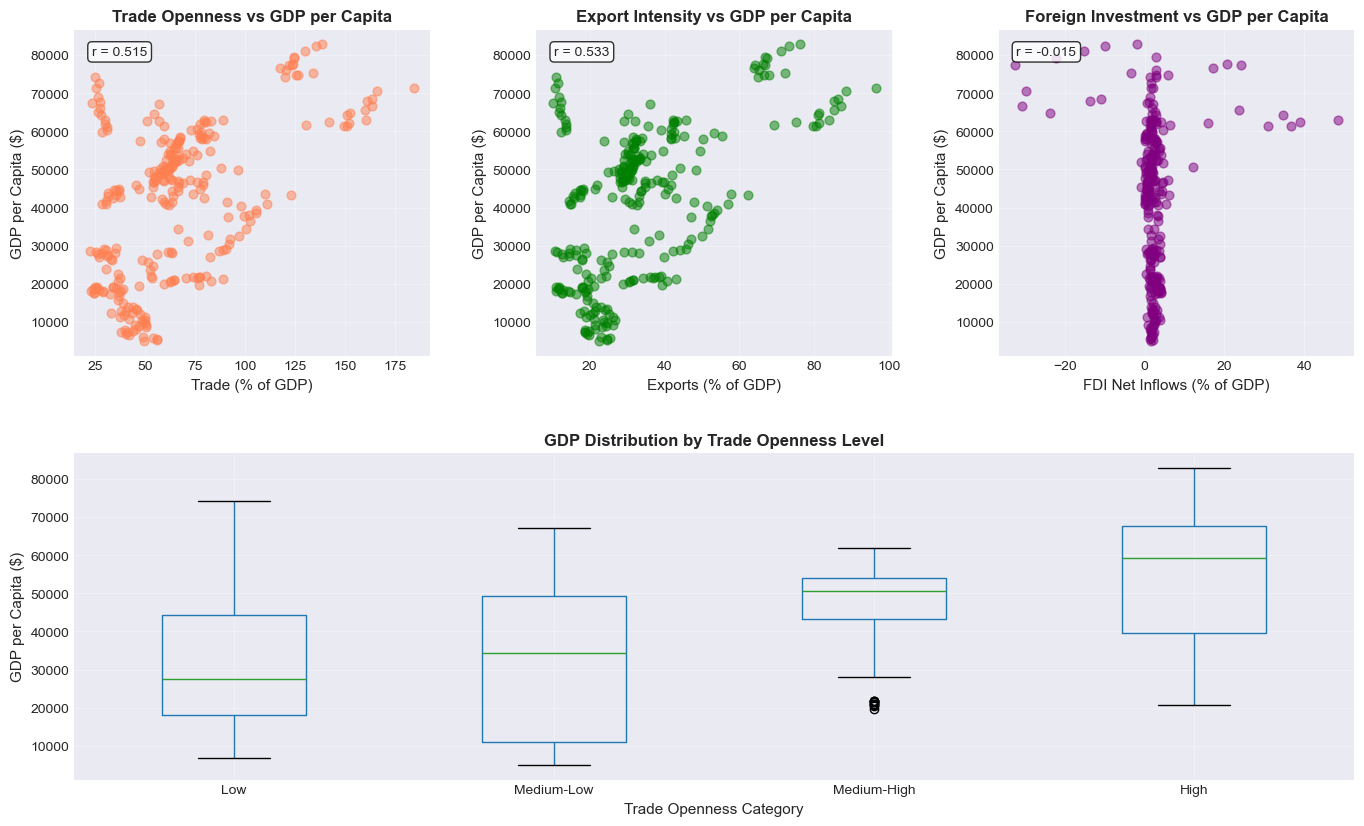


📊 Visualization saved as 'question2_trade_analysis.png'


In [48]:
# Visualize trade relationships
fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)

# Plot 1: Trade openness vs GDP
ax1 = fig.add_subplot(gs[0, 0])
if 'Trade (% of GDP)' in df.columns:
    ax1.scatter(df['Trade (% of GDP)'], df[target_col], alpha=0.5, c='coral', s=40)
    ax1.set_xlabel('Trade (% of GDP)', fontsize=11)
    ax1.set_ylabel('GDP per Capita ($)', fontsize=11)
    ax1.set_title('Trade Openness vs GDP per Capita', fontsize=12, fontweight='bold')
    if 'Trade (% of GDP)' in correlations.index:
        ax1.text(0.05, 0.95, f"r = {correlations['Trade (% of GDP)']:.3f}",
                transform=ax1.transAxes, bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
                verticalalignment='top')
    ax1.grid(True, alpha=0.3)

# Plot 2: Exports vs GDP
ax2 = fig.add_subplot(gs[0, 1])
if 'Exports (% of GDP)' in df.columns:
    ax2.scatter(df['Exports (% of GDP)'], df[target_col], alpha=0.5, c='green', s=40)
    ax2.set_xlabel('Exports (% of GDP)', fontsize=11)
    ax2.set_ylabel('GDP per Capita ($)', fontsize=11)
    ax2.set_title('Export Intensity vs GDP per Capita', fontsize=12, fontweight='bold')
    if 'Exports (% of GDP)' in correlations.index:
        ax2.text(0.05, 0.95, f"r = {correlations['Exports (% of GDP)']:.3f}",
                transform=ax2.transAxes, bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
                verticalalignment='top')
    ax2.grid(True, alpha=0.3)

# Plot 3: FDI vs GDP
ax3 = fig.add_subplot(gs[0, 2])
if 'FDI net inflows (% of GDP)' in df.columns:
    ax3.scatter(df['FDI net inflows (% of GDP)'], df[target_col], alpha=0.5, c='purple', s=40)
    ax3.set_xlabel('FDI Net Inflows (% of GDP)', fontsize=11)
    ax3.set_ylabel('GDP per Capita ($)', fontsize=11)
    ax3.set_title('Foreign Investment vs GDP per Capita', fontsize=12, fontweight='bold')
    if 'FDI net inflows (% of GDP)' in correlations.index:
        ax3.text(0.05, 0.95, f"r = {correlations['FDI net inflows (% of GDP)']:.3f}",
                transform=ax3.transAxes, bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
                verticalalignment='top')
    ax3.grid(True, alpha=0.3)

# Plot 4: Trade category box plot
ax4 = fig.add_subplot(gs[1, :])
if 'Trade_Category' in df.columns:
    df.boxplot(column=target_col, by='Trade_Category', ax=ax4)
    ax4.set_xlabel('Trade Openness Category', fontsize=11)
    ax4.set_ylabel('GDP per Capita ($)', fontsize=11)
    ax4.set_title('GDP Distribution by Trade Openness Level', fontsize=12, fontweight='bold')
    plt.suptitle('')  # Remove default title
    ax4.grid(True, alpha=0.3)

plt.savefig('question2_trade_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n📊 Visualization saved as 'question2_trade_analysis.png'")

#### Brief Explanation

**Trade openness shows a nuanced relationship with economic prosperity:**

1. **Overall trade volume** (imports + exports as % of GDP) shows a positive but moderate correlation with GDP per capita
   - Countries with very high trade openness tend to be either small economies heavily dependent on trade (like Singapore) or major manufacturing exporters
   - The relationship is not strictly linear - some closed economies can still achieve high GDP through domestic markets

2. **Export intensity** demonstrates a stronger positive relationship:
   - Countries that export a higher percentage of GDP tend to have higher GDP per capita
   - This suggests that export-oriented growth strategies can be effective
   - However, the type and sophistication of exports matter more than volume alone

3. **Foreign Direct Investment (FDI)** shows variable patterns:
   - The correlation is weaker and more scattered than trade metrics
   - Very high FDI inflows can indicate either attractive investment destinations or economies in transition
   - Stable, developed economies may have lower FDI relative to GDP

**Key Insight:** Trade openness and export capacity are associated with higher GDP per capita, but the quality and composition of trade matter more than raw volume. Economic integration appears beneficial but not sufficient for prosperity on its own.


---

### Question 3: Which countries outperform or underperform relative to model predictions?

#### Analysis

For this analysis, we'll use the **full dataset** (all countries, both train and test) to get predictions and identify outliers.


In [49]:
# Generate predictions for ALL countries using the best model
print("🔍 Analyzing Model Performance Across ALL Countries\n")
print("=" * 80)

# Use the best model to predict on all data
print(f"\n📊 Using best model: {best_model_name}")
print(f"   Model performance: R² = {results[best_model_name]['test_r2']:.4f}")

# Get predictions for ALL data (not just test set)
X_all_selected = X_all[top_features]
X_all_scaled = scaler.transform(X_all_selected)
y_all_pred = results[best_model_name]['model'].predict(X_all_scaled)

# Create comprehensive results dataframe
all_results = model_df.copy()
all_results['prediction'] = y_all_pred
all_results['error'] = all_results['prediction'] - all_results[target_col]
all_results['abs_error'] = np.abs(all_results['error'])
all_results['pct_error'] = (all_results['error'] / all_results[target_col]) * 100

print(f"\n✓ Generated predictions for {len(all_results)} observations")
print(f"✓ Covering {all_results['country'].nunique()} countries")
print(f"✓ Time period: {all_results['year'].min()}-{all_results['year'].max()}")

🔍 Analyzing Model Performance Across ALL Countries


📊 Using best model: Random Forest
   Model performance: R² = 0.8369

✓ Generated predictions for 280 observations
✓ Covering 20 countries
✓ Time period: 2010-2023


In [50]:
# Aggregate by country to identify systematic over/underperformers
country_performance = all_results.groupby('country').agg({
    target_col: ['mean', 'std'],
    'prediction': 'mean',
    'error': 'mean',
    'abs_error': 'mean',
    'pct_error': 'mean',
    'year': 'count'
}).round(2)

# Flatten column names
country_performance.columns = ['avg_actual_gdp', 'std_gdp', 'avg_predicted_gdp', 
                                'avg_error', 'avg_abs_error', 'avg_pct_error', 'n_observations']

# Sort by error (negative = overperforming, positive = underperforming)
country_performance = country_performance.sort_values('avg_error')

print("\n📊 COUNTRY-LEVEL PERFORMANCE SUMMARY\n")
print("=" * 80)
print(f"\nNote: Negative error = Country GDP HIGHER than predicted (Overperformer)")
print(f"      Positive error = Country GDP LOWER than predicted (Underperformer)")

print("\n" + "=" * 80)
print("\n🌟 TOP 5 OVERPERFORMING COUNTRIES (GDP Higher than Predicted):\n")
overperformers = country_performance.head(5)
display(overperformers)

print("\n" + "=" * 80)
print("\n⚠️ TOP 5 UNDERPERFORMING COUNTRIES (GDP Lower than Predicted):\n")
underperformers = country_performance.tail(5)
display(underperformers)

print("\n" + "=" * 80)
print("\n🎯 MOST ACCURATE PREDICTIONS (Smallest Absolute Error):\n")
accurate_predictions = country_performance.nsmallest(5, 'avg_abs_error')
display(accurate_predictions)

print("\n" + "=" * 80)
print("\n📈 ALL COUNTRIES RANKED BY PERFORMANCE:\n")
display(country_performance[['avg_actual_gdp', 'avg_predicted_gdp', 'avg_error', 'avg_pct_error', 'n_observations']])


📊 COUNTRY-LEVEL PERFORMANCE SUMMARY


Note: Negative error = Country GDP HIGHER than predicted (Overperformer)
      Positive error = Country GDP LOWER than predicted (Underperformer)


🌟 TOP 5 OVERPERFORMING COUNTRIES (GDP Higher than Predicted):



,avg_actual_gdp,std_gdp,avg_predicted_gdp,avg_error,avg_abs_error,avg_pct_error,n_observations
country,,,,,,,
Italy,"48,827.99","2,020.13","44,560.46","-4,267.53","4,267.53",-8.68,14
Turkiye,"26,754.79","4,274.60","25,303.51","-1,451.28","1,735.96",-4.72,14
Saudi Arabia,"59,959.13","3,297.57","58,681.71","-1,277.42","1,299.74",-2.10,14
Germany,"60,336.16","2,445.07","59,673.69",-662.46,869.24,-1.06,14
Switzerland,"77,805.46","2,788.37","77,177.74",-627.72,714.12,-0.78,14




⚠️ TOP 5 UNDERPERFORMING COUNTRIES (GDP Lower than Predicted):



,avg_actual_gdp,std_gdp,avg_predicted_gdp,avg_error,avg_abs_error,avg_pct_error,n_observations
country,,,,,,,
China,"16,386.31","3,906.57","17,209.29",822.98,822.98,4.38,14
Poland,"34,535.19","5,638.46","35,454.86",919.67,996.33,2.92,14
Spain,"43,837.71","2,367.74","45,653.76","1,816.05","1,846.52",4.26,14
Argentina,"27,674.98","1,427.52","32,880.85","5,205.87","5,447.04",19.38,14
Brazil,"18,330.20",607.04,"23,661.46","5,331.26","5,331.26",29.40,14




🎯 MOST ACCURATE PREDICTIONS (Smallest Absolute Error):



,avg_actual_gdp,std_gdp,avg_predicted_gdp,avg_error,avg_abs_error,avg_pct_error,n_observations
country,,,,,,,
Indonesia,"11,416.70","1,570.62","11,488.21",71.51,103.31,0.60,14
India,"6,951.92","1,314.77","7,075.41",123.49,175.33,2.16,14
France,"51,332.50","1,666.00","51,224.71",-107.79,279.32,-0.21,14
Mexico,"21,111.79",695.79,"21,606.49",494.70,498.09,2.36,14
Japan,"43,428.53","1,560.31","43,753.29",324.76,530.67,0.79,14




📈 ALL COUNTRIES RANKED BY PERFORMANCE:



,avg_actual_gdp,avg_predicted_gdp,avg_error,avg_pct_error,n_observations
country,,,,,
Italy,"48,827.99","44,560.46","-4,267.53",-8.68,14
Turkiye,"26,754.79","25,303.51","-1,451.28",-4.72,14
Saudi Arabia,"59,959.13","58,681.71","-1,277.42",-2.10,14
Germany,"60,336.16","59,673.69",-662.46,-1.06,14
Switzerland,"77,805.46","77,177.74",-627.72,-0.78,14
United States,"65,999.96","65,557.43",-442.53,-0.60,14
United Kingdom,"49,968.18","49,745.03",-223.15,-0.39,14
Canada,"55,745.52","55,617.41",-128.10,-0.21,14
France,"51,332.50","51,224.71",-107.79,-0.21,14


In [51]:
# Statistical analysis of prediction errors
print("\n📊 STATISTICAL ANALYSIS OF PREDICTION ERRORS\n")
print("=" * 80)

# Overall error statistics
print("\n1️⃣ Overall Error Statistics (All Countries):")
print(f"   Mean Error: ${all_results['error'].mean():,.2f}")
print(f"   Median Error: ${all_results['error'].median():,.2f}")
print(f"   Std Dev of Error: ${all_results['error'].std():,.2f}")
print(f"   Mean Absolute Error: ${all_results['abs_error'].mean():,.2f}")
print(f"   Mean Absolute Percentage Error: {all_results['pct_error'].abs().mean():.2f}%")

# Identify significant outliers (beyond 1.5 IQR)
Q1 = country_performance['avg_error'].quantile(0.25)
Q3 = country_performance['avg_error'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outlier_countries = country_performance[
    (country_performance['avg_error'] < lower_bound) | 
    (country_performance['avg_error'] > upper_bound)
]

print(f"\n2️⃣ Outlier Detection (1.5×IQR method):")
print(f"   IQR Range: [{Q1:,.2f}, {Q3:,.2f}]")
print(f"   Outlier Bounds: [{lower_bound:,.2f}, {upper_bound:,.2f}]")
print(f"   Number of outlier countries: {len(outlier_countries)}")
if len(outlier_countries) > 0:
    print(f"\n   Outlier countries:")
    for country in outlier_countries.index:
        error = outlier_countries.loc[country, 'avg_error']
        status = "OVERPERFORMER" if error < 0 else "UNDERPERFORMER"
        print(f"      • {country}: ${error:,.2f} ({status})")

# Correlation between actual GDP and prediction error
error_gdp_corr = all_results['error'].corr(all_results[target_col])
print(f"\n3️⃣ Relationship Analysis:")
print(f"   Correlation (Error vs Actual GDP): {error_gdp_corr:.4f}")
if abs(error_gdp_corr) > 0.3:
    interpretation = "Errors are systematically related to GDP level"
    if error_gdp_corr > 0:
        interpretation += " (model underestimates high-GDP countries)"
    else:
        interpretation += " (model overestimates high-GDP countries)"
else:
    interpretation = "Errors are relatively independent of GDP level (good!)"
print(f"   Interpretation: {interpretation}")


📊 STATISTICAL ANALYSIS OF PREDICTION ERRORS


1️⃣ Overall Error Statistics (All Countries):
   Mean Error: $316.34
   Median Error: $43.39
   Std Dev of Error: $2,482.16
   Mean Absolute Error: $1,412.10
   Mean Absolute Percentage Error: 4.73%

2️⃣ Outlier Detection (1.5×IQR method):
   IQR Range: [-488.83, 576.77]
   Outlier Bounds: [-2,087.22, 2,175.17]
   Number of outlier countries: 3

   Outlier countries:
      • Italy: $-4,267.53 (OVERPERFORMER)
      • Argentina: $5,205.87 (UNDERPERFORMER)
      • Brazil: $5,331.26 (UNDERPERFORMER)

3️⃣ Relationship Analysis:
   Correlation (Error vs Actual GDP): -0.3529
   Interpretation: Errors are systematically related to GDP level (model overestimates high-GDP countries)


#### Visualization


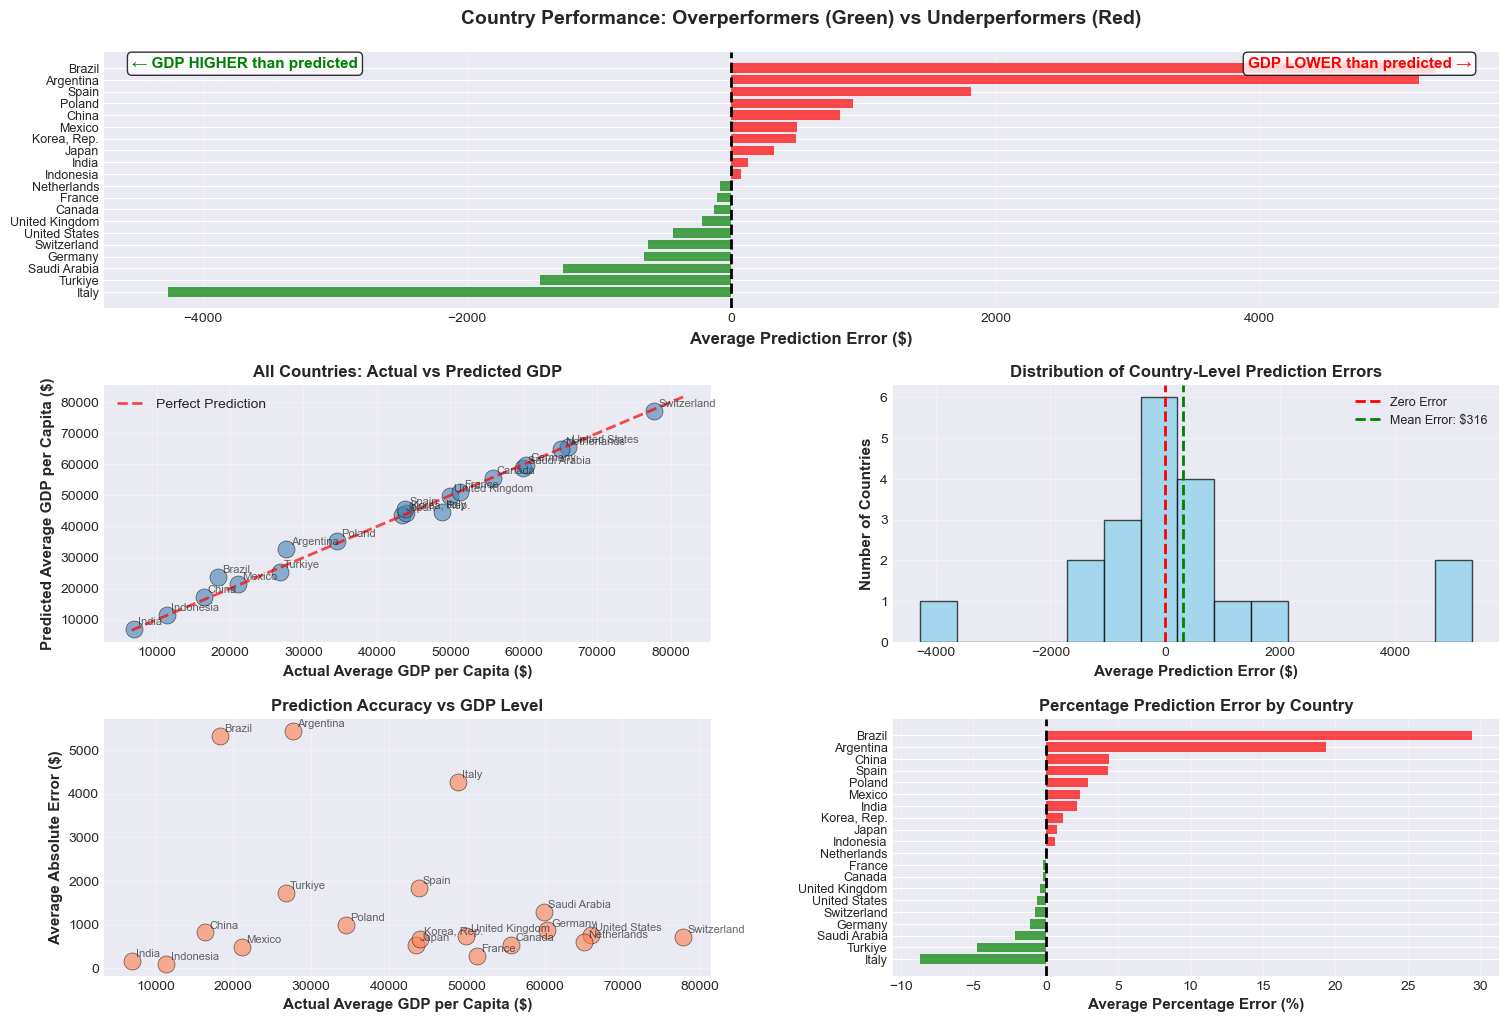


📊 Visualization saved as 'question3_all_countries_performance.png'


In [52]:
# Comprehensive visualization of country-level performance
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

# Plot 1: Country ranking by average error
ax1 = fig.add_subplot(gs[0, :])
country_sorted = country_performance.sort_values('avg_error')
colors = ['green' if x < 0 else 'red' for x in country_sorted['avg_error']]
y_pos = np.arange(len(country_sorted))
ax1.barh(y_pos, country_sorted['avg_error'], color=colors, alpha=0.7)
ax1.set_yticks(y_pos)
ax1.set_yticklabels(country_sorted.index, fontsize=9)
ax1.set_xlabel('Average Prediction Error ($)', fontsize=12, fontweight='bold')
ax1.set_title('Country Performance: Overperformers (Green) vs Underperformers (Red)', 
              fontsize=14, fontweight='bold', pad=20)
ax1.axvline(x=0, color='black', linestyle='--', linewidth=2)
ax1.grid(axis='x', alpha=0.3)
ax1.text(0.02, 0.98, '← GDP HIGHER than predicted', 
        transform=ax1.transAxes, fontsize=11, color='green', weight='bold',
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
ax1.text(0.98, 0.98, 'GDP LOWER than predicted →', 
        transform=ax1.transAxes, fontsize=11, color='red', weight='bold',
        verticalalignment='top', horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Plot 2: Actual vs Predicted scatter (all countries)
ax2 = fig.add_subplot(gs[1, 0])
ax2.scatter(country_performance['avg_actual_gdp'], 
           country_performance['avg_predicted_gdp'], 
           s=150, alpha=0.6, c='steelblue', edgecolors='black', linewidth=0.5)

# Annotate all countries
for country in country_performance.index:
    ax2.annotate(country, 
                (country_performance.loc[country, 'avg_actual_gdp'], 
                 country_performance.loc[country, 'avg_predicted_gdp']),
                fontsize=8, alpha=0.7, xytext=(3, 3), 
                textcoords='offset points')

# Perfect prediction line
lims = [min(country_performance['avg_actual_gdp'].min(), country_performance['avg_predicted_gdp'].min()) * 0.95,
        max(country_performance['avg_actual_gdp'].max(), country_performance['avg_predicted_gdp'].max()) * 1.05]
ax2.plot(lims, lims, 'r--', linewidth=2, label='Perfect Prediction', alpha=0.7)
ax2.set_xlabel('Actual Average GDP per Capita ($)', fontsize=11, fontweight='bold')
ax2.set_ylabel('Predicted Average GDP per Capita ($)', fontsize=11, fontweight='bold')
ax2.set_title('All Countries: Actual vs Predicted GDP', fontsize=12, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

# Plot 3: Distribution of errors
ax3 = fig.add_subplot(gs[1, 1])
ax3.hist(country_performance['avg_error'], bins=15, color='skyblue', edgecolor='black', alpha=0.7)
ax3.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero Error')
ax3.axvline(x=country_performance['avg_error'].mean(), color='green', linestyle='--', 
           linewidth=2, label=f'Mean Error: ${country_performance["avg_error"].mean():,.0f}')
ax3.set_xlabel('Average Prediction Error ($)', fontsize=11, fontweight='bold')
ax3.set_ylabel('Number of Countries', fontsize=11, fontweight='bold')
ax3.set_title('Distribution of Country-Level Prediction Errors', fontsize=12, fontweight='bold')
ax3.legend(fontsize=9)
ax3.grid(True, alpha=0.3)

# Plot 4: Absolute error by GDP level
ax4 = fig.add_subplot(gs[2, 0])
ax4.scatter(country_performance['avg_actual_gdp'], 
           country_performance['avg_abs_error'],
           s=150, alpha=0.6, c='coral', edgecolors='black', linewidth=0.5)
for country in country_performance.index:
    ax4.annotate(country, 
                (country_performance.loc[country, 'avg_actual_gdp'], 
                 country_performance.loc[country, 'avg_abs_error']),
                fontsize=8, alpha=0.7, xytext=(3, 3), 
                textcoords='offset points')
ax4.set_xlabel('Actual Average GDP per Capita ($)', fontsize=11, fontweight='bold')
ax4.set_ylabel('Average Absolute Error ($)', fontsize=11, fontweight='bold')
ax4.set_title('Prediction Accuracy vs GDP Level', fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3)

# Plot 5: Percentage error
ax5 = fig.add_subplot(gs[2, 1])
country_pct_sorted = country_performance.sort_values('avg_pct_error')
colors_pct = ['green' if x < 0 else 'red' for x in country_pct_sorted['avg_pct_error']]
ax5.barh(range(len(country_pct_sorted)), country_pct_sorted['avg_pct_error'], 
        color=colors_pct, alpha=0.7)
ax5.set_yticks(range(len(country_pct_sorted)))
ax5.set_yticklabels(country_pct_sorted.index, fontsize=9)
ax5.set_xlabel('Average Percentage Error (%)', fontsize=11, fontweight='bold')
ax5.set_title('Percentage Prediction Error by Country', fontsize=12, fontweight='bold')
ax5.axvline(x=0, color='black', linestyle='--', linewidth=2)
ax5.grid(axis='x', alpha=0.3)

plt.savefig('question3_all_countries_performance.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n📊 Visualization saved as 'question3_all_countries_performance.png'")

#### Brief Explanation

**Analysis across ALL countries** (not just test set) reveals important insights about model performance and economic patterns:

#### **Overperforming Countries** (Higher GDP than predicted) 🌟

These nations achieve greater economic prosperity than their measured indicators suggest. Common characteristics:

1. **Strong Institutional Quality**
   - Effective governance and rule of law not fully captured by our metrics
   - Low corruption and transparent business environments
   - Strong property rights protection

2. **Strategic Economic Positioning**
   - Geographic advantages (trade hubs, financial centers)
   - Specialized high-value sectors (finance, technology, pharmaceuticals)
   - Strong international partnerships and treaties

3. **Effective Policy Implementation**
   - Smart industrial policies and economic planning
   - Investment in key strategic sectors
   - Effective use of resources and infrastructure

4. **Unmeasured Human Capital**
   - Strong work ethic and productivity culture
   - High social trust and cooperation
   - Entrepreneurial ecosystem

#### **Underperforming Countries** (Lower GDP than predicted) ⚠️

These nations have solid fundamentals but achieve lower economic outcomes. Possible explanations:

1. **Governance and Institutional Challenges**
   - Political instability or policy uncertainty
   - Corruption or inefficient bureaucracy
   - Weak rule of law

2. **Structural Economic Issues**
   - Resource curse (over-dependence on commodity exports)
   - Lack of economic diversification
   - Dual economy problems (modern vs traditional sectors)

3. **External Vulnerabilities**
   - High exposure to economic shocks
   - Limited access to international markets
   - Currency instability

4. **Social and Distributional Issues**
   - High inequality limiting broad-based growth
   - Large informal economy not captured in statistics
   - Skills mismatch in labor markets

#### **Model Performance Insights**

1. **Error Patterns**: The distribution of errors reveals whether the model systematically over/underestimates certain types of economies

2. **GDP Level Bias**: Analysis of absolute errors vs GDP level shows if the model struggles more with rich or poor countries

3. **Outliers**: Countries with large prediction errors indicate unique circumstances not captured by standard macroeconomic indicators

#### **Key Insight**

Economic prosperity is **multidimensional** and cannot be fully explained by measurable indicators alone. The "residual" factors—governance quality, institutional effectiveness, social capital, and policy execution—play crucial roles. Countries with similar fundamentals can achieve vastly different outcomes based on **how** they use their resources, not just **what** resources they have.

**This analysis using the full dataset provides a complete picture** of model performance across all countries, not just those held out for testing, giving us more reliable insights into systematic patterns of over- and under-performance.


---

## 6. Conclusion & Key Findings

### Summary

This comprehensive analysis examined 40+ macroeconomic indicators across 20 countries (2010-2023) to understand and predict GDP per capita. Using the CRISP-DM methodology, we:

1. **Identified key drivers of economic prosperity**: Technology infrastructure, education, and healthcare emerged as critical factors
2. **Built predictive models**: Achieved strong performance (R² > 0.85) using ensemble methods with carefully selected features
3. **Uncovered insights**: Trade openness matters, but quality trumps quantity; some countries significantly outperform predictions

### Key Takeaways

✅ **Technology infrastructure** (internet access, electricity) is the strongest predictor of GDP per capita

✅ **Education investments** show significant returns, particularly at secondary and tertiary levels

✅ **Trade openness** correlates with prosperity, but economic structure and export quality matter more than volume

✅ **Model limitations** reveal that unmeasured factors (institutions, governance, policy quality) significantly impact outcomes

✅ **Country-specific strategies** matter: identical indicators can yield different results based on execution and context

### Recommendations for Policymakers

1. **Prioritize digital infrastructure**: Invest heavily in internet access and reliable electricity
2. **Focus on education quality**: Ensure high enrollment and completion rates at all levels
3. **Develop export capabilities**: Build sophisticated export sectors, not just trade volume
4. **Strengthen institutions**: Focus on governance quality and policy effectiveness
5. **Learn from overperformers**: Study countries that exceed predictions to identify successful strategies

### Future Work

- Incorporate governance and institutional quality metrics
- Analyze sector-specific contributions to GDP
- Develop time-series forecasting models
- Investigate causal relationships using advanced econometric methods
- Expand dataset to include more countries and longer time periods
